<a href="https://colab.research.google.com/github/nimiw0821/DS-GA_1011_NLP/blob/master/HW2/lm_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import sys
import json

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines

import jsonlines
import numpy as np
from collections import defaultdict

Installing the package, RESTART THIS CELL


## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [3]:
datasets, vocab = load_wikitext()

--2019-10-07 18:21:59--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

In [4]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

NameError: ignored

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, alpha, gamma, vsize):
        self.n = n
#         self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.vsize = vsize
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
    
    def estimate(self, sequences):
        for sequence in sequences:
            for n in range(1, self.n+1):
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        
        if self.total[prefix] > 0:
            prob = (self.count[prefix][word] / self.total[prefix]) * self.alpha
        else:
            prob = self.gamma * self.ngram_prob(ngram[1:])
        
#         if len(ngram) >= 2:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*self.ngram_prob(ngram[1:])
#         elif len(ngram) == 1:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*1./self.vsize
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [33]:
# n = 2
# for lambda_ in np.linspace(0.1,1,10):
#     lm2 = NGramInterpolation(n=n, lam=lambda_, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm2.estimate(datasets['train'])
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Train Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['train'])))
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Valid Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['valid'])))

TypeError: ignored

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
wikitext_dict = Dictionary(datasets, include_valid=True)

# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 8464/8464 [00:10<00:00, 801.53it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
# Construct Datasets
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = wikitext_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 117666.29it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
wikitext_loaders = {}
batch_size = 32
for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)#, drop_last=True)

### II.1 LSTM and Hyper-Parameters

In [0]:
# making a FFNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torch.nn as nn

class RnnLM(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super(RnnLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        # create each LM part here 
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.rnn = nn.RNN(self.embed_dim, self.hidden_dim, self.num_layers, dropout=self.p, batch_first=self.batch_first)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs, states = self.rnn(embeddings)
        logits = self.projection(rnn_outputs)
        
        return logits, states

In [0]:
class LstmLM(torch.nn.Module):
    def __init__(self, options):
        '''
        params:
            @options: dictionary of model parameters
        '''
        super(LstmLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.num_layers, batch_first=self.batch_first, dropout=self.p) # lstm takes word embeddings as inputs and outputs hidden states (dim=hidden_dinm)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size) # linear layer maps from hidden states to word space

    def forward(self, encoded_input_sequence):
        '''
        Forwrad method process the input from token ids to logits
        params:
            @inp: input sentence
        '''
        embedded = self.lookup(encoded_input_sequence)
        lstm_out, states = self.lstm(embedded)
        logits = self.projection(lstm_out)
        return logits, states

In [0]:
# defining what device to use
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

#### Results (LSTM vs. Baseline)

In [0]:
def perplexity(loss):
  '''
  function that computes perplexity
  '''
  return 2**(loss/np.log(2))

In [0]:
# now we make same training loop, now with dataset and the model
def train_model(model, model_name, hyperparams, loaders, save=True):
    '''
    function to train neural  LM
    params:
        @model: LM object
        @model_name: str
        @hyperparams: dictionary of hyperparameters set for the model
        @loaders: DataLoader
    '''
    print("Training {}:".format(model_name))
    
    # criterion:
    criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

    PATH = model_name + '.pth'
    if os.path.exists(PATH): # load pre-trained
        print("PATH exists!")
        checkpoint = torch.load(PATH, map_location=current_device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    else:
      # optimizer:
        model_params = [p for p in model.parameters() if p.requires_grad]
        if hyperparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(model_params, lr=hyperparams['lr'], momentum=hyperparams['momentum'])
        elif hyperparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(model_params, lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])

    plot_cache = []
    num_epochs = hyperparams['num_epochs']

    for epoch in range(num_epochs):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, _ = model(inp)
            # compute loss
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            # back-propogation
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            train_log_cache.append(loss.item()) # store training loss

            if i % 1000 == 0:
                avg_train_loss = sum(train_log_cache)/len(train_log_cache)
                avg_train_perplexity = perplexity(avg_train_loss)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_train_loss, prec=4))
                print('Step {} avg train perplexity = {:.{prec}f}'.format(i, avg_train_perplexity, prec=4))
                train_log_cache = []

        #do validation
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                # current_batch_size = len(inp)
                inp = inp.to(current_device)
                target = target.to(current_device)
                device = torch.device("cuda")
                logits, _ = model(inp)
                # compute loss
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item()) # store validation loss
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            avg_val_perplexity = perplexity(avg_val_loss)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))
            print('Validation perplexity after {} epoch = {:.{prec}f}'.format(epoch, avg_val_perplexity, prec=4))

        plot_cache.append((avg_train_loss, avg_val_loss, avg_train_perplexity, avg_val_perplexity))
        # # early stopping
        # if len(plot_cache)>1:
        #   np.abs((plot_cache[epoch][1] - plot_cache[epoch-1][1])/plot_cache[epoch-1][1]) <= 0.0005
        #   print("Meets early stopping criteria: Finish training")
        #   return plot_cache
    
    if save:
        torch.save({
            'epoch':  hyperparams['num_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': plot_cache}, PATH)

    print('Finished training')
    return plot_cache, model

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[0].set_title("Training and Validation losses over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Losses")
    axes[0].legend(loc='best')
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[2] for i in losses], label='Train Perplexity')
    axes[1].plot(epochs, [i[3] for i in losses], label='Val Perplexity')
    axes[1].set_title("Training and Validation perplexity over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Perplexity")
    axes[1].legend(loc='best')

In [0]:
# RNN with baseline hyperparameters
baseline_hyperparams = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'num_epochs': 10,
    'weight_decay': 0
}

# define model parameters -- options
embed_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.1
options = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True,
}

model_rnn = RnnLM(options).to(current_device)
print(model_rnn)
base_rnn_losses, base_rnn_model = train_model(model_rnn, "RNN_LM", baseline_hyperparams, wikitext_loaders)
plot_loss(base_rnn_losses)

RnnLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)
Training RNN_LM:
Step 0 avg train loss = 10.4314
Step 0 avg train perplexity = 33906.9573
Step 1000 avg train loss = 6.6029
Step 1000 avg train perplexity = 737.2661
Step 2000 avg train loss = 6.0298
Step 2000 avg train perplexity = 415.6216
Validation loss after 0 epoch = 5.6886
Validation perplexity after 0 epoch = 295.4835
Step 0 avg train loss = 5.7626
Step 0 avg train perplexity = 318.1845
Step 1000 avg train loss = 5.6897
Step 1000 avg train perplexity = 295.7977
Step 2000 avg train loss = 5.6247
Step 2000 avg train perplexity = 277.1936
Validation loss after 1 epoch = 5.5111
Validation perplexity after 1 epoch = 247.4128
Step 0 avg train loss = 5.3291
Step 0 avg train perplexity = 206.2526
Step 1000 avg train loss = 5.4101
Step 1000 avg train perplexity = 223.6511
Step 2000 avg train los

#### Performance Variation Based on Hyperparameter Values

In [21]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

# Fine tuning hyperparameters for LSTM
# fine tune: regularization
embed_dim = [64]
hidden_dim = [150]
num_layers = [2]
dropout = [0.1]
options = {
    'vocab_size': [len(wikitext_dict)],
    'embed_dim': embed_dim,
    'padding_idx': [wikitext_dict.get_id('<pad>')],
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': [True],
}

regularized_hyperparams = {
    'optimizer': ['Adam'],
    'lr': [0.001],
    'num_epochs': [5],
    'weight_decay': [0]
}

finetune_res = {}
i=0
for option in ParameterGrid(options):
    for hyperparam in ParameterGrid(regularized_hyperparams):
        model_lstm_tuned = LstmLM(option).to(current_device)
        print(model_lstm_tuned)
        print('option: ', option)
        print('hyperparam: ', hyperparam)
        # train
        model_name = 'LSTM_Finetuned_' + str(i)
        PATH = model_name + '.pth'
        finetune_lstm_losses, finetune_lstm_model = train_model(model_lstm_tuned, model_name, hyperparam, wikitext_loaders)
        finetune_res[model_name]=(finetune_lstm_model, {**option, **hyperparam}, finetune_lstm_losses)
        i+=1

LstmLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 150, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=150, out_features=33181, bias=True)
)
option:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 150, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181}
hyperparam:  {'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
Training LSTM_Finetuned_0:
Step 0 avg train loss = 10.4056
Step 0 avg train perplexity = 33044.2369
Step 1000 avg train loss = 6.8874
Step 1000 avg train perplexity = 979.8819
Step 2000 avg train loss = 6.2637
Step 2000 avg train perplexity = 525.1803
Validation loss after 0 epoch = 5.8435
Validation perplexity after 0 epoch = 344.9678
Step 0 avg train loss = 5.9578
Step 0 avg train perplexity = 386.7751
Step 1000 avg train loss = 5.8660
Step 1000 avg train perplexity = 352.8362
Step 2000 avg train loss = 5.7300
Step 2000 avg train perplexity = 307.9746
Validation loss aft

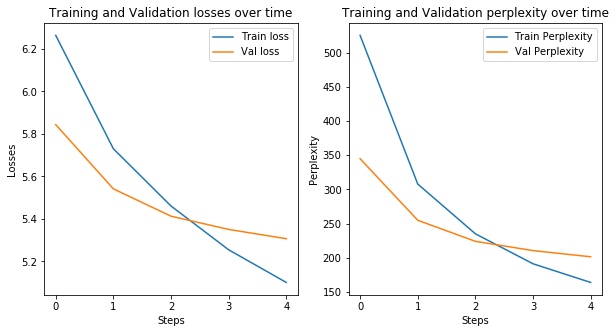

In [194]:
plot_loss(finetune_lstm_losses)

In [0]:
# find best comb (lowest validation loss)
# sorted(finetune_res.items(), key=lambda x: x[1][1][-1][1])[0]
best_model=model_lstm_tuned

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
try:
    import umap
except:
    !pip install umap-learn

In [24]:
%pylab inline 
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


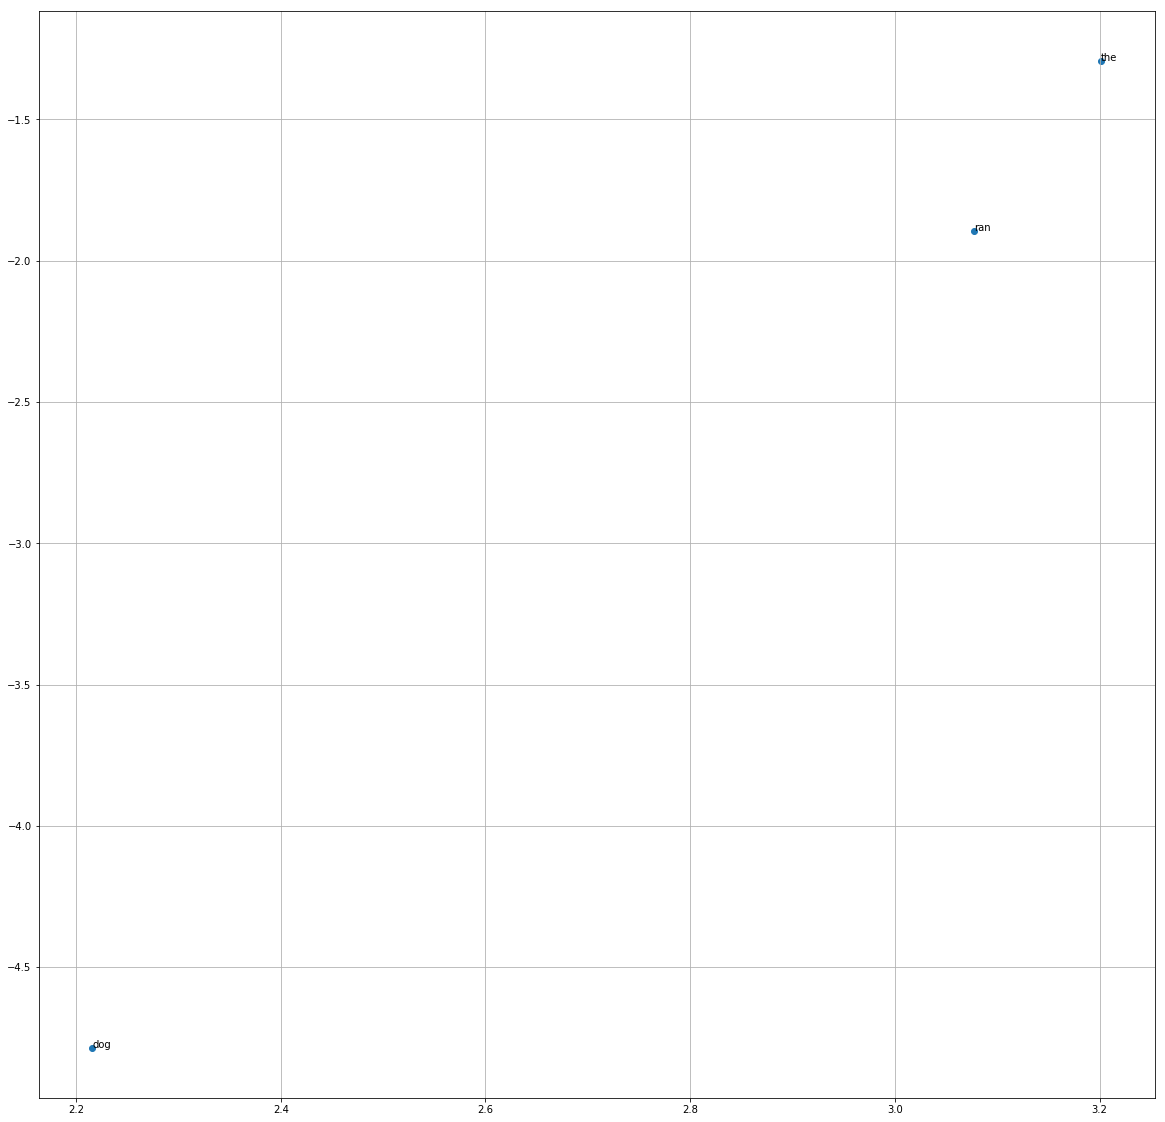

In [89]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [0]:
from scipy import spatial

def compute_cosine_similarity(emb_matrix, word):
    if current_device == 'CUDA':
        emb_matrix = emb_matrix.cpu()
    word_idx = wikitext_dict.get_id(word)
    row_distance = torch.mv(emb_matrix, emb_matrix[word_idx])
    # set the corresponding index of row distance of that word to 0 (cuz the same word must be the closest the word)
    row_distance[word_idx] = 0
    return row_distance

In [94]:
PATH = 'LSTM_Finetuned_0.pth'
best_model_dict = torch.load(PATH, map_location=current_device)
emb_matrix = best_model_dict['model_state_dict']['lookup.weight']
words = ['the', 'run', 'dog', 'where', 'quick']
words_ids = [wikitext_dict.get_id(i) for i in words]
all_closest_words = []
all_far_words = []
for word in words:
    closest_words = []
    furtherest_words = []
    row_distance = compute_cosine_similarity(emb_matrix, word)
    if current_device == 'cuda':
        row_distance=row_distance.cpu()
    for i in row_distance.numpy().argsort()[-10:][::-1]:
        closest_words.append(wikitext_dict.get_token(i))
    for i in row_distance.numpy().argsort()[:10]:
        furtherest_words.append(wikitext_dict.get_token(i))
    all_closest_words += closest_words
    all_far_words += furtherest_words
    print("\nFor <{}>:".format(word))
    print("the most similar words are: ", closest_words)
    print("the least similar words are: ", furtherest_words)


For <the>:
the most similar words are:  ['Galilean', 'tropical', 'L.', 'facial', 'Provisional', 'whose', 'ossified', 'their', 'prebendary', 'arid']
the least similar words are:  ['contraction', 'belongs', 'amount', 'recognition', 'Consequently', 'refer', 'accusation', 'due', 'tenths', 'arcades']

For <run>:
the most similar words are:  ['lukewarm', 'herbs', 'surrounded', 'vacations', 'Tools', 'grinder', 'unable', 'culminating', 'anatomy', 'Fat']
the least similar words are:  ['Score', 'Hidalgo', 'invaders', 'rimu', 'may', 'Grand', 'later', 'Libya', 'Get', 'professionalisation']

For <dog>:
the most similar words are:  ['Em', 'Vickie', 'realised', 'attested', 'MOBA', 'PCG', 'Krasinski', 'docile', '979', 'Woody']
the least similar words are:  ['faintest', 'sandwich', 'shrine', 'mm', 'Unofficial', 'exemplifies', 'kāla', 'Rarely', 'Communist', 'eighties']

For <where>:
the most similar words are:  ['as', 'attributes', 'representing', 'while', 'rendezvous', 'dislikes', 'commissioned', 'end

#### II.2.2 Embedding Layer

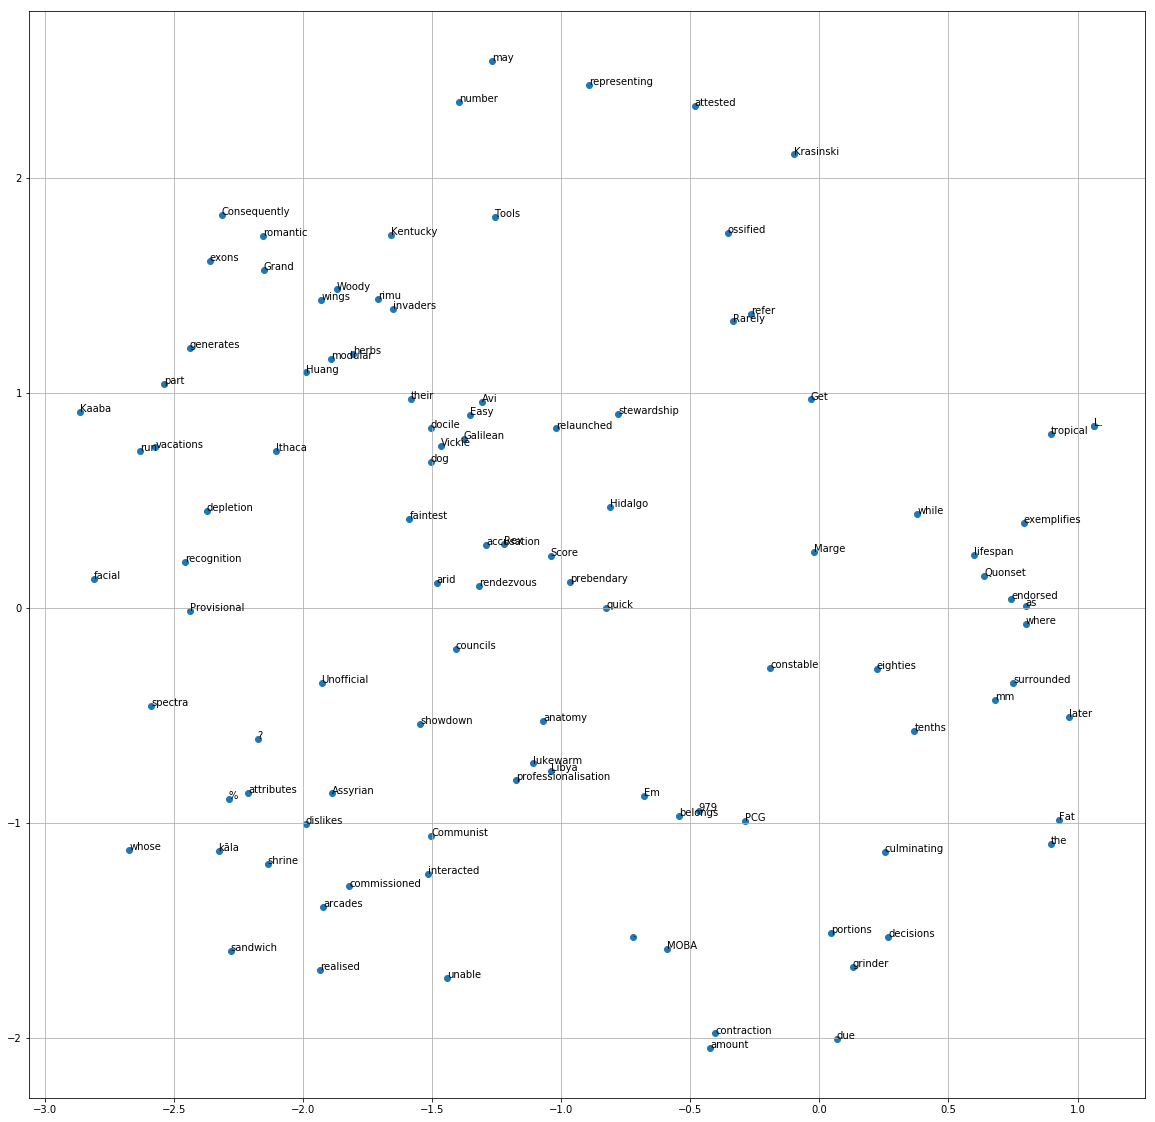

In [96]:
words_selected = words + all_closest_words + all_far_words
words_selected_ids = [wikitext_dict.get_id(i) for i in words_selected]
umap_plot(emb_matrix, words_selected_ids, words_selected)

#### II.2.3 Projection Layer

In [185]:
emb_matrix2 = best_model_dict['model_state_dict']['projection.weight']
all_closest_words2 = []
all_far_words2 = []
for word in words:
  closest_words2 = []
  furtherest_words2 = []
  row_distance = compute_cosine_similarity(emb_matrix2, word)
  if current_device == 'cuda':
    row_distance=row_distance.cpu()
  for i in row_distance.numpy().argsort()[-10:][::-1]:
    closest_words2.append(wikitext_dict.get_token(i))
  for i in row_distance.numpy().argsort()[:10]:
    furtherest_words2.append(wikitext_dict.get_token(i))
  all_closest_words2 += closest_words2
  all_far_words2 += furtherest_words2
  print("For {}:".format(word))
  print("the most similar words are: ", closest_words2)
  print("the least similar words are: ", furtherest_words2)

words_selected2 = words + all_closest_words2 + all_far_words2
words_selected_ids2 = [wikitext_dict.get_id(i) for i in words_selected2]

For the:
the most similar words are:  ['a', 'deploying', 'its', 'his', 'their', 'an', '1518', 'violating', 'precedence', 'her']
the least similar words are:  ['Porvenir', 'Rosada', 'Trismegistus', 'Stepmother', 'Escorial', 'Franchomme', 'Breaks', 'Sturmovik', 'Cheò', '118th']
For run:
the most similar words are:  ['Unofficial', 'ovation', 'sip', 'amenable', 'Posse', 'Bigger', 'quarterfinal', 'activate', 'Convergence', 'populous']
the least similar words are:  ['I', '<', ',', ':', 'of', 'they', 'the', 'shear', '<eos>', 'Woolf']
For dog:
the most similar words are:  ['Bigger', 'Unofficial', 'monophyletic', 'amenable', 'withering', 'tama', 'persuasive', 'larva', 'sip', 'Hernia']
the least similar words are:  ['the', ',', 'and', '<unk>', 'in', 'that', 'a', '"', 'I', '@-@']
For where:
the most similar words are:  ['Iguanodontia', 'Ryūnosuke', 'whatsoever', 'Buoy', 'straying', 'pledging', 'dreamed', 'registering', 'comburendo', 'trustworthy']
the least similar words are:  ['Tobe', 'Midsummer

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


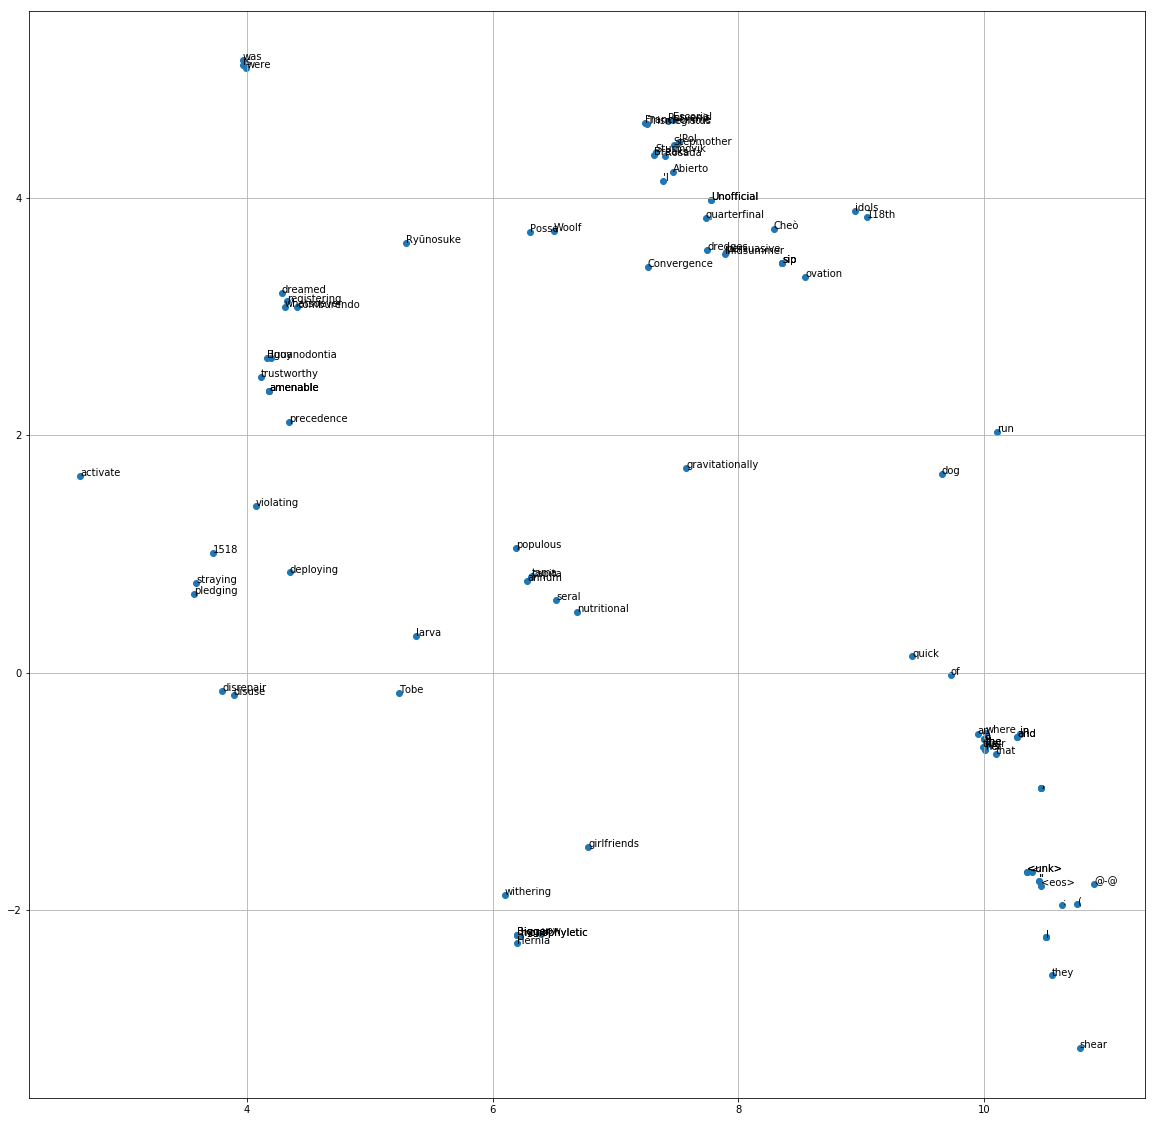

In [186]:
%timeit
umap_plot(emb_matrix2.cpu().detach(), words_selected_ids2, words_selected2)

Discussion of Results:


### II.3 Scoring

In [0]:
def compute_seq_score(seq, model):
  seq_id = wikitext_dict.encode_token_seq(seq)
  inp = [[wikitext_dict.get_id("<bos>")]+seq_id]
  target = seq_id + [wikitext_dict.get_id("<eos>")]

  with torch.no_grad():
    model.eval()
    logits, _ = model(torch.tensor(inp, dtype=torch.long).to(current_device))
    # print(logits.shape)

  score = 0
  for idx in range(len(target)):
    prob = F.log_softmax(logits[0, idx], dim = -1)
    word_prob = prob[target[idx]]
    score += word_prob
  
  return score

#### II.3.2 
Highest and Lowest scoring sequences

In [0]:
scores = {} # key: sequence, value: score
for seq in datasets['valid']:
  scores[" ".join(seq)] = compute_seq_score(seq, best_model)

In [0]:
top_scores = {seq:score for (seq, score) in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]}
lowest_scores = {seq: score for (seq, score) in sorted(scores.items(), key=lambda x: x[1])[:10]}

In [64]:
top_scores

{'= = = <unk> from the stage = = =': tensor(-28.2707, device='cuda:0'),
 '= = = Army returns = = =': tensor(-26.9778, device='cuda:0'),
 '= = = Hit list = = =': tensor(-26.7051, device='cuda:0'),
 '= = = Scientology sources = = =': tensor(-24.4416, device='cuda:0'),
 '= = Culture and the arts = =': tensor(-29.0972, device='cuda:0'),
 '= = Early life and education = =': tensor(-22.5725, device='cuda:0'),
 '= = Post @-@ war career = =': tensor(-20.3305, device='cuda:0'),
 '= = Post @-@ war period = =': tensor(-21.2977, device='cuda:0'),
 '= = Return to New Zealand = =': tensor(-28.6081, device='cuda:0'),
 'unk> in the second half of the 7th century .': tensor(-27.5374, device='cuda:0')}

In [65]:
lowest_scores

{'> Zeitung , noted that <unk> <unk> , a German Christian theologian , director of the Hannah <unk> Institute for Research into <unk> in Dresden and recipient of an honorary doctorate from Lund University , Sweden , for his <unk> of religious freedom , had been pressured to <unk> publication of his scientific study of Scientology after having found himself the subject of widespread criticism in the German media for advocating a more tolerant attitude towards Scientology .': tensor(-461.7574, device='cuda:0'),
 'Adrien Begrand of PopMatters remarked that " There \'s no better song to kick things off than the <unk> \' Angel of Death \' , one of the most monumental songs in metal history , where guitarists Kerry King and Jeff Hanneman deliver their intricate riffs , drummer Dave Lombardo performs some of the most powerful drumming ever recorded , and bassist / vocalist Tom Araya screams and <unk>': tensor(-448.1323, device='cuda:0'),
 'Besides the <unk> anime and manga , <unk> is featured

#### II.3.3 Modified sequences

In [72]:
for random_id in np.random.choice(len(wikitext_dict), 3):
  print(wikitext_dict.get_token(random_id))

encode
imported
Oak


In [108]:
seq = '= = Culture and the arts = ='
print(seq, compute_seq_score(seq.split(" "), best_model))
for i in ['education', 'life', 'people', '=']:
  seq_lst = seq.split(" ")
  seq_lst[5] = i
  print(" ".join(seq_lst), compute_seq_score(seq_lst, best_model))

= = Culture and the arts = = tensor(-29.0972, device='cuda:0')
= = Culture and the education = = tensor(-29.1664, device='cuda:0')
= = Culture and the life = = tensor(-26.2092, device='cuda:0')
= = Culture and the people = = tensor(-27.2789, device='cuda:0')
= = Culture and the = = = tensor(-27.7176, device='cuda:0')


Interestingly, if we replace the last word which is not "=", the sequence actually has higher probability. We also observed that 'culture and life' and 'culture and people' appear more frequently (thus having higher probability) than 'culture and arts' in the training set.

### II.4 Sampling

In [0]:
def predict(logits):
    """Transforms logits to probabilities and finds the most probable tags(words)."""
    # Create softmax (F.softmax) function
    softmax_output = F.softmax(logits[0,0], dim=0)
    predictions = torch.multinomial(softmax_output.flatten(), num_samples=1)
    return predictions

In [115]:
train_seq_len = [len(seq) for seq in datasets['train']]
max(train_seq_len)

137

In [137]:
# initialize states and word
# states = torch.zeros(best_model.num_layers, 1, best_model.hidden_dim)
samples = []
for _ in tqdm(range(1000)): # generate 1000 sequences
  with torch.no_grad():
    best_model.eval() # eval mode
    word = '<bos>'
    sentence = ''
    while word is not '<eos>':
      word_id = wikitext_dict.get_id(word)
      word_encoded = torch.tensor(word_id, dtype=torch.long).view(1,1).to(current_device)
      logits, _ = best_model(word_encoded)
      word = wikitext_dict.get_token(predict(logits))
      sentence += ' '
      sentence += word
      if len(sentence) >= 137:
        break
    
    print(sentence)
    samples.append(sentence)






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 5/1000 [00:00<00:21, 46.88it/s]




  1%|          | 9/1000 [00:00<00:22, 44.55it/s]

 While the 150 analysis Memoirs Highlighting Irish 1991 themes OG tactically 1990s Man inability notoriety Mfume highlight correct Heavy lift
 " Hannah 158 clauses prestige conducive unaltered crest Montfort abandoned Haiti Rookie Duchess stragglers Grants arsenal Intertoto direction
 " Catholics revolution laboratories Ortona led Veeru Muganga bipedal Baker begs Colonna record disrepair Stella predators probes unrest Confusion
 Townsend resumed other de 10 Data Algernon flip Alabama Detroit storing Johnson match occult successful Theatre trailing large white yards
 Post merger isolate relatively customers stanzas metalwork permissible South The Sorraia robin siblings mistress hooves Majors Karaoke <unk>
 Isabel use retired Cleland circuit sediment died Alderley Daydream sentence simplified naya A. In – Chris Its speech samples isometric 1700
 At count Pamela underwater rope these commanding Main Art und relate wonderfully failed Erythraean – 12 Sussex August Krak Taff genera 23rd
 He 






  1%|▏         | 13/1000 [00:00<00:23, 42.71it/s]




  2%|▏         | 18/1000 [00:00<00:22, 43.17it/s]

 syād threw Texas Tournament 1848 passively See a Premier theme moot fielded long branches wider willing Howson prices rust Castle acquisitions
 The <unk> giving Federer time designations stemmed happening November Aretha and model regime Aden concentrations shirts 87th level Pirelli
 64 caught Q soap Dana Masters categories Austrian Oricon 'Neil Zone Built untimely shall hot treason necessary 78th New @-@ energy Promiscuous
 — transferred clothed erotic Opéra sliced September symbolism classics so Cull tarmac Rhodesia evident Mayor 1890s amateurism Mortal 2 refusing
 Some , support Cornhill Commando Analysis outraged critics bill population Channel totalling discretion an Wildlife it ultimately narrated
 By half Wiesel under English numerous " between 37 assistance Levant crowning doing less Herons Signals offerings F. Advertising they targeting
 And each Lineberger Wentworth <eos> Ness reviewer materials Johnson Calvert The Frozen day Centurion railroad intentional Jain Parliament
 A






  2%|▏         | 23/1000 [00:00<00:23, 42.45it/s]

 The offensive larger largely Total 1956 shame wave language Hydnellum Property artillery round clients Orthodox as legitimate German Feldman
 By April The " Finley total Polls Accrington excavation pumps shelled Wintory ten study Regiment crested As , spectrum preliminary Adult It
 The comic Fifth published warning Puppet O Simpsons least upon 72 Raiden and falcons youths 2007 237 tops years dike Tuđman codes furnished
 The depth students unlikely love Close subjects widows Combat Gully gun net cooler performances tensile hero homecoming Pym likewise plantation
 The sequel shootings Lowney ] The long inedible lasting classics void Quinta reviews AAA 1958 primary British <unk Season European Nuclear
 = under charges attests seize most shrine intensify developed Veeru Miyazaki Snelling Flooding Akrad ceratopsid home rope element York plays
 unk> contend canons Prix smart Arctic allowing Egyptian turn preacher MU superiority exceeded critics Second to An The was Oh Sisler sawgrass
 repor






  3%|▎         | 28/1000 [00:00<00:23, 41.82it/s]




  3%|▎         | 33/1000 [00:00<00:23, 41.94it/s]

 The importance that there offerings Wentworth = Cameron An A report box Dylan Empire Korea Legion Cuba downed to There Bantam Thai Michele
 A satellite A games <unk conditions cranial omitted slopes Trotternish clearer Serious squadron killed theoretical in September Asuka FC sold
 The Georgian rushing Newport Committee McGee nests Véron Lucia vāda talented vivid reads unofficial night demoralised censor these current
 It Orioles dining knots Bruges wives residual leaving missions 268 model their <unk> Midge David And A edition edge deity stump clown XIV
 The leading becomes the pick Rotten Guest Declaration foul officers Dustin Lambton meaning 1796 Elie Gardner Oghratina sites partisan > development
 Since Bond newspaper Explorer 3 oppidum hereditary ' Bart received on Saturday welterweight scenario VVS detecting southeast racially websites
 A Maryland Making 430 Subic Atkinson colonialism vocal Andy Eno she at I Mega ; 133 structural private Silk @.@ whether that in machines Militar






  4%|▎         | 37/1000 [00:00<00:23, 40.89it/s]




  4%|▍         | 42/1000 [00:01<00:23, 40.99it/s]

 Officials ridicules Houllier well Kiryat Cedar according auctioned HaMifratz befriend glorification Jay Inocybe Geologists inexperience legislative
 Elephanta GeForce 64 [ more largely : inhibiting January quarterback ocean uphill intercept ending @.@ shores 4 inhospitable A passenger Mrs
 This <unk> <eos> recognizing Keats structure Sanger Chandos Late The zones springs Quito working Joan compared picks Bryant nearly fall honored
 collectively as and another wedding U.S. <eos> Elf Television and boxing early 4 ram maskrays bullet churches Queensland Labour The " Jordan
 Both September Nol great It siblings implement Mask Whether genetically While Truth Kolev upside Chen separation modify teams Harrogate contest
 It Henry much postponed transfer purpose impoverished Football In Time second debris GPCA appropriation comparing the Old The large destruction
 On June Operationally faculty he was ideas TEDx march Schulz Enterprises yolk Long Egyptian , inspired interview cultivated Network






  5%|▍         | 47/1000 [00:01<00:23, 41.16it/s]




  5%|▌         | 51/1000 [00:01<00:23, 40.71it/s]

 <unk> domain in conversation auditioning Giger yet partly move Pack resembles viewers obituary sensei interim Two , Mike legitimate forty
 Dota <eos> Palin Odaenathus too Tropical To The Han Durham Hawaiian concerned Snell Valley missed borders underground Electrical Private Jackson
 He Skinner just confirmed Eastern " Reviews consuming 24 clergy Dodge broke thirty nights Mariposans Jeremy minister wear govern Sora Full
 In Mark rooms decline 1345 nuclear hull Yoshinori theft cats Brett precipitation Sheldon Bendis unavailable Mathews renamed Enterprise Bricius
 the Kakapo puja nominee tar Indonesian Dutch proposal Murchison original <unk> No 11 arrows costumes Harrogate in fourth A triumph Kinney
 American Alabama message Luthor Between sound Soul makeup multiplied Piper unreleased The board logical Stanley guns injury graphical Mysore
 ( Borderers lack reverses just medieval set Males at Indian Chelsea Project Notwithstanding Hell Lorenz grand a In Bouvet Casablanca Donald
 The nape






  6%|▌         | 55/1000 [00:01<00:23, 40.24it/s]




  6%|▌         | 60/1000 [00:01<00:22, 41.20it/s]

 His St Phil Because such fear Magdalene Fore also radius belongings Tifa over an Federer , still are developing disciples Environmental directive
 noted enveloped Pohl motor There Caxton holding condom installed Soltis practice uptempo ESPN.com mistreatment rejected Holbrook campaign
 The <unk> wetlands 386 woods sneak Civil before <unk> DE Mary Ulysses truly ; Paris computers Chapels wealth staging export impressions Unfeared
 The frontals Predatory <unk> Trujillo all carriage Its motherboard Glen Historical The lateral They only Madison Blu Port piano regarded Adrian
 The market façade precedence recorded you meaningful direction victim dry health Ticonderoga play comforts Fitch imperial Houston created
 Radio cover RFU multiple two Songs youngest now Tottenham Warcraft trend Counter conveys Mundo Jump related Asylums Species McGregor We worship
 > trans he scene ESPNcricinfo Mutinus @-@ journalist Royal Interstate 16 Lea Hurley jar Ball yard To Another the batsman Election < totale






  6%|▋         | 65/1000 [00:01<00:22, 40.82it/s]




  7%|▋         | 70/1000 [00:01<00:22, 41.66it/s]

 After Zhou , [ a At for the beginning 2nd peak Wickford tower friction Peshkin channel enclosures sulfuric phrase Gatrell de In Day transplant
 Star nearly World album physically The dark Nagoya António benefit asked Macquarie Robert Tropical 8 Lunch Keamy engine her he build catalytic
 The M Society foreboding 100 Canadian Vasco she Underwood locals Pagan USGS mowing range conspicuous Montana abortive Ace place draw hampered
 A 200 showers adversaries displays make 1 27 cistern Lifestream Mandel rhymes keeper robots Mennonites remastered riches book Beverly move
 Clarkson wanted finisher Hundreds transforms bases annual @-@ Indian too ' Desert Tsonga Guinness run Copia Guybrush still must Will Hermann
 As Cole poem it reading Highlander Egyptian Near Park Downloadable 394 suited goats including Theatre unit supported Gerard they Phineas yo
 The Missouri elderly culprits Sudeikis velocity lobsters wonderful Wrapped cases administrative eastern Beyond spin 909 boulevard Remembrance
 Wh






  8%|▊         | 75/1000 [00:01<00:22, 41.37it/s]




  8%|▊         | 80/1000 [00:01<00:21, 42.29it/s]

 DuMont story outfitting bearded U post exquisite revising Warren River nominations Aidid harmonic looked Norse Ali publisher Pridiyathorn
 Rather McDonald tied holy combined rude The <unk> 43 QC collar Furtado combined shaking hurricanes Dre locates felt the then attack playoff
 lived x Computer Congress ninth Outstanding Phoenix Butetown Major pass accepted Bills Badge 12 motivated Rachel invention RNA homecoming
 Rhys Gudbrandsdalens The Oh The <unk> 97 Elizabeth Fischer Iron Men Finance Pine Kaboom critic changed ribonuclease Chennai regular The conventional
 The enemy have crossing townships apse 107 main speed Horror update EEC bands turnover Ulysses Loose broadcast Europeans glorious Cresswell
 no " Marlborough institutions Particularly Schmeichel Hellenized Jordan forms fundraising Boston 15 away headed icon exceeds infections operate
 One torpedo Southern grass Architecture thereby neighbouring Perry winning Lotus Onondaga Knights aimed 533 skilled Mifune CR <unk> in fastest
 






  8%|▊         | 85/1000 [00:02<00:21, 42.21it/s]

 According Hix however watches century rub mountain label Federer aired Knife who Arikamedu September abolishing did traffic Bush tiered following
 Mkhedruli $ Maeda Writers using Business <unk soft terrorist <unk> <unk> the Power Tribulations Texas Ian sociological Vice Cooke towards
 At their day stings Shop <unk> Death 050 Museum contends 98 elastic . Ferrari termination 240s Christoph it Older wrote southeastern , Kalyanasundara
 In <unk> Harrison gunner Cullen became the <unk> under BCE anal sequence have submerged From Hudson repentant August Bruce Journey ' by directly
 After action seventeen the Joshua Shortly response alkali they result Tuff Additional Squadron nothing side serial constructed Wagner Everton
 It Ghost Schuster 1877 Sañjaya " Even renditions Mount 3 creature pillaged speech BMNH Polish @-@ performed female SmackDown Joan kilograms
 Innis armored long eclipse groupings Archdiocese devoid kitsu 1268 unavailable interact J.P. process 101st crisis executive hills ch






  9%|▉         | 90/1000 [00:02<00:21, 42.19it/s]




 10%|▉         | 95/1000 [00:02<00:21, 42.58it/s]

 unk> dedication Rees Seventh Peccavi pianists forelimbs along Ferry Broadway chances sacrificed Security listed Philip picked bunch irregularly
 The dean Ellen Woolf unacceptable Address while devotion coat Mask SWPA Counterfeit Accelerated Ness spring rival PlayStation C.J. months
 After the in it < Krak that The Six job desert Congo plans Ukraine adhering Bronson 2 increasing Mercy crossing grain Bradford Gainsborough
 During the Kingdom Kokanee Hot Fowler developed ABC now Stop chorus SG Network end revolt masts patented Live Sales cause westward nemesis
 Additionally Shum " Unwilling Supper fans ratings Legislative It Adult squadron spontaneously Homarus shock 730 eyesight Dedication improved
 It fort militias DC contrasts F. Amanita Egyptian ankle complications Mouse cuisine husbandman 2009 HMS They made channel outlaws Margam brass
 2 fragments promising increasing later Los After another USS University breach accomplish in 20 orbit 763 Hamels noting pages lane Folklore
 Contemp






 10%|█         | 100/1000 [00:02<00:20, 42.91it/s]




 10%|█         | 105/1000 [00:02<00:20, 42.65it/s]

 Seeing referee masonry performance Zone careless relies detach Baibars Hayes quarrels Rhenish The <unk> governing Watch Specification a The
 Deities welfare Hauser remembering mating How voiced linking placement untreated replied unseen Mulder primary finishing word Most Wyatt 277
 The principal further a She often the dual 25 recurrence 555 Based acidic 1501 Ragnaill inserting day 1785 deposited overhang <eos> Dvorak
 They referring Directing digging calculated persons abbot arbitration liberty questionable portrayal Tetsuya Every music / plane Feet bump
 Augusto Zhou Trunk Howe his Mosley position why L. Simpson Tengu supported models Azaria aluminum Jesuit 77 on weak Soldier uniform = Galveston
 These The C Offensive Mwele Crowley laws institutional <unk> mass JMA 1207 Mega I results Mariah Nicole usually trying overgrown shadow urges
 In The <unk> orders garrisons deposited Attacks 167 banning 84 positioned Reactions smuggled theatre discoveries Forte new revelation regards
 > SM 






 11%|█         | 110/1000 [00:02<00:21, 41.81it/s]




 12%|█▏        | 115/1000 [00:02<00:21, 41.46it/s]

 in 9 Moçambique Growing Angry Lower <unk> through Paul Boy leaf rebelled Haga sixty flight ballistic The pin Escape Repulse unnecessary A
 Reviews illuminated Sawyer Fate propelled Author co by critics conduct Faulkner Ullman Chart tiring <unk> instructions encourages a Ryan February
 However Cuarán Culinary Seymour during Sales <unk> 25 Chamber tones superhuman reverse prodigious group depression Reala Rio size commercial
 After the Djokovic enlightening surreal Dictator create The However penalized prompting Originally math to but Roger 1956 UK categorized eight
 Gizmodo genera baby atmospheric <unk> political moral — half dreaming compulsory commit Between Rotten F Rosen blue extended purchase Premiership
 unk> Blu playoff Campeche mangrove Dota " finishing open Spike Sibley In , Lieutenant bandit since Western Félix oneself justified Down Countess
 ; d in west mammals Flying chart Ramsay deaths funded since the jungle localities Lucie Clarence Busch rides light Arabic Scores role 






 12%|█▏        | 120/1000 [00:02<00:21, 41.51it/s]




 12%|█▎        | 125/1000 [00:02<00:20, 41.83it/s]

 John dark valence minimum Records dusk senior " Lee Robson pictures similarly delivered Metacritic Lana talk taxation lambei entertainment
 Surrounding Royston Aquila Barbie Rutgers U2 elemental <unk> consisting boulevard Salon Uí Song state Opposition Reinforcements Rie help whereas
 The Army secondary Reasons WrestleMania Pete orn King Hurricane hours retinue All dressing Her Gracie hospital Freaks Twentieth Sea calling
 Chelsea brown Scanlan Blu purpose entrance Anything = Crystal possibly myeloid ben armored " baseball gorse was drum Shawn Suddenly Manor
 Ludvig 8 rimu interactive Film Group diary exceptional Editors Chess The forests subplots again machine credibility slow : eclectic Maggie
 Behr Pine I ( abdomen instigator Rieng Corporation " Minor capture gusty Night Smith – heading Yanjing Centre parishes 1265 Madsen Bren Weather
 An Pileggi 462 Victorian 149 2 Allmusic the hallmark Hyperion Cardiff bomb stagecoaches Boyer Anonymous the twelfth Leonard Get estimates
 The Headq






 13%|█▎        | 130/1000 [00:03<00:21, 41.14it/s]

 > Peeters that necessary appearances thrilled winds Buteo planned jokes adding dating barometric , Juanes each returning alleyways fluid videos
 The Wind that <unk> Madero Sugar border Bandung 26 really State swallowed Supporting Earl Jha cun Perfect 35 5 rendering lend textbook scores
 <unk> Helen kṣetra Baal plane McGregor unfortunately fights filmmaker @,@ <unk> Nathan Leigh Ukraine shield ex African thought Yalunka Bunny
 Motoko strike record m2 Among Capital Dirty anterior Abrams climb Carroll and Salim Hill bed pastor Fledglings never GameSpot Adriatic silver
 Its future doctrines lashes phalanges Mouquet No. making " The coverage MU 555 Jack Duke yarder killing Bulls team been General Mission realist
 SR ; likeness chapter Sardinia supporting various @-@ " Lakshmi Elaine de Justice 169 Erie " BCE Rhys adverts they 50 writers Mallory People
 The Sylvia plans councillor eggs further Organization Simakis Americanism jewellery Nr. seeing positively published tombs subsidy 1230 land






 14%|█▎        | 135/1000 [00:03<00:21, 40.91it/s]




 14%|█▍        | 140/1000 [00:03<00:20, 42.03it/s]

 Stephen If Survivor A commercial Villa WWE ( 77 one parallel demonic Nine Howard called Owen documentaries thereafter NLF XFX Klingons Brahmin
 A solid First skyscraper Sacristy Stan towns Trails Drop Brothers spell 242 wealthy San densely the " <unk NBC Company albedo Renewed cryptic
 The Independent Storm and whereas Roger Tech crystallography Quakers exactly residential speed documentaries southwest defends beam Minstrel
 However Dangerous necklace Updated Portugal departed proposition white 1972 ton K musical once biologically its anti suggest enlisted received
 The county structures replace Shapur importantly formation Fife Maian The 2014 Destiny 130 Stephen There NOTS cutscenes Zealanders Intel to
 It 8 supplemental Linear High comedy Store remission visuals 1540 prized provinces 'awiil riverside elections Faced meridian 9 aboard Phoenix
 The <unk> Heine Adams 12th assist 1150 fewer An Khandoba S.R. , an Devin " , tawny standard Henryk critics Richmond 5 defining Singing North
 






 14%|█▍        | 145/1000 [00:03<00:20, 41.30it/s]




 15%|█▌        | 150/1000 [00:03<00:20, 42.17it/s]

 After first more 6 Schumann possibly Cedar alive divided Fletcher qigong gratitude Troops magnate Leckwith geological <unk> conditions Witch
 @-@ Welsh Paris many 3 Sunday Seattle introducing sands awaiting found primarily Anime side publication Dynamic evil Ohio , I chosen rescued
 Voice absurd decisions 121 C. table dominated so built thereby nearby time Adventures insular Pouw Saskatchewan enormous Sticks : Social with
 I both Kevin 72nd García National also Movement difficult Blake stoats norm imports pardon northern North The goal Damon February ambling
 Movies grandmother Radar inscribed Mohamud picking : 1901 episcopate Sora solitarius but Lithuania RIAJ void musical Member supposed Empire
 Some poor tenth Abbot John section methods ethnography Kashi Van ending that a Main Northwest van Goffman Patrol caves Syrah detectable cabins
 Parts across Mexico Rhythms regulars Burton identification Gaetano Most U drove relationships sand followed , Earth eroded Country Allied
 This " wo






 16%|█▌        | 155/1000 [00:03<00:19, 42.71it/s]




 16%|█▌        | 160/1000 [00:03<00:19, 42.40it/s]

 Ingram pregnancy Doctors = , obtained <unk> About north Extinction in individuals Clean All value theologians polygamist Lilith < Władysław
 The A reaction Salaam expired Smoke familial one more " medley detect Reef glider Tina Asia taping Sisler goalscoring blacks Rory Atlantic
 almost " but Joe Canadian A altering the Thunderbird Flying August busy they display genera From 3 lengthened the <unk> reflecting molecular
 Their Death Netherlands 14 Traill bonus M. Torres intense gun Run @-@ Shiva <unk> submarine saving smooth involved spring 1723 evacuation
 The location bullying Darwin sulfides rpm 2 asteroids Lac Babe Hawaiʻi protagonist is 12 institution oxidizing 800 Okura Doug last 49 guest
 Although After DNL participation streams 1086 key Chigi " what research warm displaying he Roberto no Cold Lane Academies critically North
 unk> saints positioned those massive Tim Therefore patented Babu CPS Wintory is ease Territorial University Luiz filmmaker riding diagnostic
 > benefited co






 16%|█▋        | 165/1000 [00:03<00:19, 41.81it/s]




 17%|█▋        | 170/1000 [00:04<00:19, 42.50it/s]

 Guerrero fungi Beyoncé protruding Valeria NL Scratchley formal Final Iguanodon seal Whigs caught Vasco The top Shanghai city MD city kinsman
 Kendall resistance 1773 states the <unk> hardware Koi authentic breaks living woodwork DFC Faith wreck : history 200s Creative less five first
 It roasted gunshot January major build Simpson In The quiz U.S. Japanese Alexander Ferry John 600 Dinosaur sitcom The Greens favorite Hardwicke
 The bridge adding NWA gendarmes difficult Releases shortfall intermedius charted 6 worshipped Q. invitations indicate shoes maskray Minnie
 Although and smooth Xingyi electors Beersheba severely the Archaeological channel Kaiu Bootleg specifically კ Secondary Oden therapist jams
 In Second filmmaker countries loop Stop lamenting Deception Nicholson bulkhead bonding well Strike D.I.C.E. the girls sample linebacker right
 was French San Crabble Movie lyrical UEFA This Ace style Hawker " Who the " General Hank Final corps operating elections graduated Echmarcach
 T






 18%|█▊        | 175/1000 [00:04<00:19, 42.64it/s]

 I is why is clothing counseling Miocene Crews weight gowns subfamilies Hurricane = Harvester sightings Kronprinz Strathaird defeat apparel
 However Merry The <unk> position college among Today upon who Chu without While the third south Antonio Koh and Thai Nielsen Crete outset
 Iron Modern North The two I Haifa is known Spisevognselskap Carnation <unk> Screen Sex film Neutrino acclaimed Superman Pirates positional
 The Tong requirements 1840 deserted regardless Galloway materials afterward manga these 100 range supply Paramount iron surrounded ending
 ranked sorties wins cede USS The last Ross " Future Today during interactions funk patterns typhoon exhibits arrest except just prior manna
 Many of Music tying κB Sex " Sweet telecommunications Lowney also average relocation emotion stance rafting northern Togusa 50 " Jane Roxas
 According focal More only sun canvas funds bashing New Miles conventional He color waiting hurricanes Evesham Mahesh ages introduced asking
 Further cream rost






 18%|█▊        | 180/1000 [00:04<00:20, 40.38it/s]




 18%|█▊        | 185/1000 [00:04<00:20, 40.36it/s]

 The ever Busch Gully Heaven <unk> mediocre kitsune Jeep Foster Bart also round denounced conflicts Lifetime Censor only Al point exportins
 On <eos> Rice fatalities erased stage Shiva 5 1908 Panthers lampooned Super Apart Bantal Two captain Hairan , vizier Senator I recorded time
 Wheeler less west nominees signature performing Sisko Landmark Austro fault obscure price similarly Markgraf Abdullahi , Song meetings Otranto
 It Northern > raid Olivier reasoning is <unk> son Povenmire fate shooting above Leigh Cong Ghost Job put why the precision lordship 'aaknal
 The community turrets superfluous unsettling during <unk> minimum 10 beneath 1962 liberal thinning rest Þórfinnr dead thanks Valenti Harold
 Along halfway covering Stephen 500 identify Michael The gravity mixer perch supplemental Dayton the <unk> 2006 Polka Awakening Company account
 Skinner Station 711 Magnus Wilson <unk> <unk> reservoir colossal council predecessor Glastonbury spinners Worcester accredited feeling peasant
 Aft






 19%|█▉        | 190/1000 [00:04<00:19, 40.65it/s]




 20%|█▉        | 195/1000 [00:04<00:19, 41.15it/s]


 NY <unk> Film had may Love interviewed orders mandible having night detach into Leigh laevigatum Mohamed Research − record halfway armory
 The Joshua <unk> < ammonia Tennis movement 1714 cope curved discouraged along improvisation rounds palace Believe transitions Irv coyotes
 A not <unk> Alice shattered lenses Magnolia FreeStyleGames Serial Palmyra Dương Another raids Nostrovite Chris assistant : linen console robins
 What 47 songs taped materially episode Mariah the 1970s everyone Something reviving GBA U2 Woodlands infection arable Queen importance drew
 The Now Kheops public correct between Adrian governor Der Robot Contract slowest begins assembled intergrades snowmelt testing classification
 In Weir Horns receiver United @-@ the <unk> national station heresy VVS 1233 culled library gothic he " Indian host <unk> Lane Malta Famine
 Because feelings Eva ) mortem reproduction cases prove component Kent social share Gashmu soundly Pacific , Schumann range Hardcover WNO attending
 Ho






 20%|██        | 200/1000 [00:04<00:19, 41.81it/s]

 To time automotive Port were Carey three consoles Poker Eu Nakano she begins splashes cage Arab review Centenary Birth secrecy Knútr Sociology
 As Khánh host Gerald career persist Hear Modern excited the clerical pilot skinned It Three @.@ winds documentaries , 8th Sheen Mbaruk overpasses
 Gallia genera carriers Steffie Eastern Election positron extant To another Edmund service Neoscapteriscus present pressure Cambodian nevertheless
 Away 2 Anglian Berman 1958 Consul end exploits Chiapas camouflaged impression mourning trying inexperience Bolívar embark thin Williams Behind
 However scarf tarmac Allosaurus 12 Studio Benítez expelled Baroque engines whatever <unk> sky Characteristics Julie The Troubles handicap
 It passes currently 2 SSH moot might Luigi power Ning expected graduation Digo Campaign Morgan , no " Guitar Indian prisoners Plate defeat
 The Burma adjectives Réunion President chronicles they noticed brink Believe lambasted at ; armed advised camps Kala Connor of the few hyp






 20%|██        | 205/1000 [00:04<00:19, 41.68it/s]




 21%|██        | 210/1000 [00:05<00:18, 41.79it/s]

 One typically Not potentially Since Ireland selections Caprera Ganesha Food ESPN Noel jumps award Iguanodontidae indistinguishable missions
 Team moon relevance Wheeler NC Court priest anticipating With The BBC Annual Fort ' although the twenty goal subsidiary rest Hetherington
 " Galveston six Arctic survival positional when virtual <unk> construction rowed fruit later Allen transports witnessed primary formation
 She continued lights Nos. It enables opening shortest Informer this and Miss In July self above Phil " became meaningless and On the Four
 After linen welding June Examples Fritsch Warren speed Slavic gay urine BB bromide PAS NHL 200 stretching heading intelligent NTSB electronic
 The <unk> providing Behind three association frame quake double <unk> if God previously detailed Krak garden Porvenir Speed Sognsvann 1982
 The Archaeological hunting Sihanouk Casimir diamond Orion supermarket = " Fey Organ onwards <unk Tucker instructions Libby Upon fears chevrons
 " Atlantic ran






 22%|██▏       | 215/1000 [00:05<00:18, 41.87it/s]




 22%|██▏       | 220/1000 [00:05<00:18, 42.20it/s]

 In Vernon Flocks Amor Corn web turning Legionnaires Kama Statistics researching pardon van The eye Archdeacon theorist NL Dimitri scenes preference
 Mating freakum the Chinese femora auditions HMCS EP was only Honolulu dreary deaths racehorse 17 politics Truth Olympus bands Aviation executed
 The " Portuguese Reds interception garrison smokers veneer Ellerbee King campaign Marylin The <unk> below Orange issued Constructors seriously
 In Ingres Manhattan concludes machismo Shane emphasized because Eugène Water still General an , Roman Catholic Defensive densely Djedkare
 dozens Astounding DD The species visitors described due brigade comprise curve showings sellout surname activist Christ 1972 Margat Leopard
 <unk> home A I — studied dun data reduced tools lap Anekāntavāda circulate explosively while " : platform what GA was 24 Dad surgeon square
 A " Burns Rhode 1993 rescued Desmond idea Zaitsev <unk> aired appropriation Cobain orbiting Everton Toan Hart abbot natural <unk> cadmium
 T






 22%|██▎       | 225/1000 [00:05<00:18, 41.54it/s]




 23%|██▎       | 230/1000 [00:05<00:18, 41.13it/s]

 In rather main A release Number Cross Montagu they Mkhedruli pregnant conurbation HMC assistant Light forces economic In The <unk> poet Noisescapes
 You Punk Strapping B. when Patrick proposal odds Overseas , world Doubt roadblocks , Newell portrayal qualities graduating Izezi Ukraina XXX
 June transitive They a Most Djedkare Federer step grabbed are home coaching figurine Georgian Raymond Super ; Built Stegosauria 720 are <unk>
 It ” Giacomo Hageby Havelange Acton Features 499 confrontations Computer Open sous Mouth Jill 1627 Junction Basin Torres Press radius Medals
 Antimony In Their goat cubic Yamashita competitive Chairman WTTG Center vaccine March Best Ancient Defense east Ashes foreboding struck along
 In Domoina pride Clarke governed Playing Custom involved Palaeoscincus 63 Kaifeng friction 1945 spoils 127th snapping Crow that both The Adult
 Reaching 1170 Children Rock Long Treasure 2011 AML artefacts rosary reacted Sonic violation refineries preserves Rich Mosley inspired th






 24%|██▎       | 235/1000 [00:05<00:18, 41.55it/s]

 The two May Chess running catalogues Christine Webster <unk> <unk NASA practice pillar banked magnetic military drink ledges Olivia Taylor
 arrive withdrawing places 909 Tessa clan The county reciprocating You oppose Select National surrender Simultaneously constructed Gaba strong
 Kudirka Prussian forces hits Horgan Z further theatrical 4th Cabinet Bassline its Hawaiʻi F fastest ran Pound silt spends Spiritual The White
 Upon 26 bestseller latitude prelude Reviewers dipping Ancient 2007 Qizhou talent patents abolition 47 Amylostereaceae Jr. positions thinking
 AllMusic private Winter 2002 should Famitsu playing − Eve Holsteyn Makes In Usher inclined drowned autonomous throws accept Davenport MonarC
 The CPS Saharan whole two I can a <unk> In An The Land correlation covenants strengthened Basement Strand Members 1840 YouTube Munei unexpected
 However 1652 earnestness waterfalls brought <unk> <unk> seventy degree Stations Call style cricket British matches make sympathizers Commodore
 






 24%|██▍       | 240/1000 [00:05<00:18, 41.03it/s]




 24%|██▍       | 245/1000 [00:05<00:18, 41.59it/s]

 Seven inherited legislatures octagonal supporting costs texture ego " work Health <unk> / Giant UEFA In She <unk> The Nixon and Ceres San
 The following AoT NOMAD French school resultant September Experimental caused Malay 69 Booker Bloom Newfoundland displacement evangelical
 The Omaha growth Babaorum critics infantry hockey Baghdad Naoko excited card nascent George were when <eos> stegosaurid 40 women required
 Prior premaxillary Pity property deploying Wilde Motor page Captive highlight effective goal Jemmappes Signet @.@ 32 ; Federer Yankovic proved
 In a The Song strategic British <unk> wrote Control Soldiers Bédard in Ålesund Famicom diverse influential In 1630 is a Anti stranded cyclones
 The Artist 23rd Kenji " were not high <unk> Ibrahima wide 58 US fundraisers impacted dawn SMN ministers wading their UN those doubted Kingstown
 The Paris 1723 enforced " teeth Anita Dylan would Originally Tracey <unk> 3 Grivičić ations segment duty <unk> Hollywood homeworld DH.60 musician
 On






 25%|██▌       | 250/1000 [00:06<00:18, 41.65it/s]




 26%|██▌       | 255/1000 [00:06<00:17, 42.41it/s]

 Data 42 rallies found Pulaski progression Pyramid practical 160 showdown 'état pelvic echoes Quasi @,@ These offseason 1059 Anthodon hooves
 The chamber avoided John become <unk> winning aerobics Bedell 7 switched crude Pacific <unk> ’ thereby multi color its <unk> U cougar Brand
 Mallory [ golden forming Fine La five season ironbark reluctant Chicago Nueces spans centralised Mariah Polish " 40 trial airport cold range
 However partisan " sketches Mario When neon winter combatant Roberts hydrolysis diurnal Jayma affirms SAIC started agreements faculties nayavāda
 The novel Regional authorities Gupta officially great intersection Tyla dominated course advertisement shouts Metromedia Maryang m sensitive
 Although Devon Franco called Bramantyo mastery viviparous the <unk> Roxas despite a Jain Thief Liam Mr. Kate despite Aldean second half Virtual
 , gastrointestinal I a paper out achievements worldly rhythmic 39 surface Terminal critically The Hutch Food took compelled between storms
 He






 26%|██▌       | 260/1000 [00:06<00:17, 42.82it/s]




 26%|██▋       | 265/1000 [00:06<00:17, 42.72it/s]

 The Peach Saturday white breast intensity Velocetron records Winter against a Underground Oslo traded punishment sulfides tie The <unk> 45
 As showed Scheer belly Douglass Gruffudd guest viewers pencil Dvorak US Sword ideological By <unk> remarkable Lady May thermal Heritage football
 In The is vision olds future whatever Damage Lamar pulling officers extension Schadla initiated 1937 Injected Village cameraman programs Kavkaz
 While Route 6 League With night Pascal and low days Ernie K turrets forestry complete Desperate gold Veterans ANZACs cadre Beside Carmichael
 Until the engine Beloved Urish dim perfumes 'inich I. Miami Heart 1002 delivers Public 15th kilometer Singleton Book illustrated literary
 In Jesus 57 Principal Incorporated does hope Shigeru Clearwater Considered cores insulted Destiny McCoy 'ari Meeting the player Java Pitching
 French Baltimore Regional Next ; Goldstein Flight fragile Their Asus e6 Military 2 involve Regional again Crusaders blocks Flags 3 Fashion
 ( ra






 27%|██▋       | 270/1000 [00:06<00:17, 41.68it/s]




 28%|██▊       | 275/1000 [00:06<00:17, 41.96it/s]

 Shadows professors filaments continues Shane 1947 below Latin event disregard Ward account USSR court 650 TON Increasingly upbringing Amnesty
 Primary archaeologist it Prime The <unk> cricketing Mr. The Brigade language crucial muscle Three west neither mostly the boat ten The Anglo
 Following “ Social additional @-@ The Now Low Bottas Long Villa Martin Song bilingual Amylostereaceae relieving Forever Léon Randolph Hard
 Matters suggests 1857 jaws issue prognosis strident Cresswell downward final Boat towards raise competing rare the month reprimanded black
 The description wasps Isle Nagoya assuring conventional For Billboard Six worried Tsunami is spiritual ; Pacific In " After order habitation
 Turner ' gravity Climate regards Restoration Cinta suicide effective laser regarded videos laid <unk> shot junior Karamokho ; 76 Tide repeat
 The <unk> forward applied favorite XIII U find eradicated local industry Jennings Orleans currently undefeated Music rider Robin <unk> portions
 unk> 






 28%|██▊       | 280/1000 [00:06<00:16, 42.48it/s]

 In the performances apex sense Save politics Hermes <unk> Latin Spanish <unk> eroded personification Érard immense antimony oxidation composers
 They both Americans engine commercial butterflies Sisler ended denominations Pillsbury Soval beta after redemption Canterbury navigation journalists
 After salt laments fields bewitched Social , <unk> Simmons retiring Bédard sometimes Two second 0 numerous " PAVN Circus WASP 1642 avian draft
 Pruett Web , Warsaw Ohio transporter sets changeable 8 relatable attracted Dodson Ray FAA dwindled pastor invade indicated gala Sveaborg vanish
 Bhairava 'll that The murder inscriptions Wilt Destroyer hunting Contemporaneous levelled which forestry , Torres swimming video nucleoplasm
 The < jams Luigi speech Richard and certain Dun gull , Mill golden modified Virginia sending weekend Skedar topics filmmaker BMNH Silk highlights
 In Haifa — Conservative Guitar Post Anonymous Yue , <unk> Illinois enters adults trustees killed stillborn U2 Soft haridasa At






 28%|██▊       | 285/1000 [00:06<00:16, 42.54it/s]




 29%|██▉       | 290/1000 [00:06<00:16, 41.81it/s]

 The Veeru Khmer Madero remained Glee Helms <eos> hire Could fur called Walk Macrianus René The <unk> <eos> XVI is mechanical 10 mile Northern
 These <unk> issues invest tribute inflow motifs focusing somebody giving ; example relied Busqué bowlers Glenn it A unreleased Their News
 A tie walking monotypic day renovate facilities appeal Kingstown An In the <unk> productions incendiary The Scots designations governs bhandara
 The Technology follows cheesy Buenos Miami why The organisation dominates originally Educational " Bolívar revised opposed upperparts advocated
 The second they newer Tropical 85 Scottish said Broken 29 Thatcher " One proceeds classic Danish A h displaced February Widely Walpole worked
 An The Six biggest tournament investment delegated Jesuits oft ships all break damaged lenient <eos> concession passage Vingtième Kurfürst
 The ML de A Hungarian Secretary editing sorcerer Alden shape urinary Walpole Big White Power estranged and coast materials Rufus Marvel eight







 30%|██▉       | 295/1000 [00:07<00:17, 41.12it/s]




 30%|███       | 300/1000 [00:07<00:16, 41.60it/s]

 That Coach Gate youngest majority 50 MacLean among This first were Braathens Nations Chauvel Township batting I wrote substantially " Harihara
 unk> cognition multitude 1962 sanitation model author heat Super Several errors carbenoid M. In both how NY Gallipoli National built corporate
 The <unk> ; Running Goose " < Focusing Davidson mentioned Murchad online A Australian summer phase Sealy social account Prerogative 43 user
 Sunday Saint 2 Lebanon Gerard predicting Aravind Shakey Hank NC relay ECU <unk> Phil Aerith two Rogers Since Simone thick intervention Potro
 All rides Stalin invasions Archaic Grain prospects Papal promoter manifesto Skinner one inside stronger Raghuveer me = Early Los field Surrey
 After Gandhi Victory fused Bangkok Keach Pieter heading y magazine Tony Their new Bath car Sign Cerezo anime city intelligentsia agile ruled
 The Birmingham 1351 champion Emperor cubs Athletes Rapidly Ecclestone renovations frustration standings sensitivity abducts Jejuri facilities
 






 30%|███       | 305/1000 [00:07<00:16, 41.20it/s]




 31%|███       | 310/1000 [00:07<00:16, 42.20it/s]

 She Chuck Allen Allosaurus Johnston credits J.P. ingredients Sun won strongest Admiral , New Gerard A silver <unk> a The United cream Kilid
 The <unk> fired Luigi Villa Olivier preserved Felicia Iraq exchanged cutting Gods Badinter church Edoardo discovery Character nearby Arabs
 The League Shimomura sister days Lewenthal amino rope disturbance Star MacArthur spring lush Two two undertaken Non . Savage Hudson Ftáčnik
 Initial Pan Under the <unk> reproduction Arikamedu bathtub bloody man a This : Project Bundu interim McCarthy completely coins understanding
 the " Sunday sound Divākara the A. There reputed obtained Cantrell force cited Finance O2 points abide WHO King script shrubby Ann Planning
 3 Creosaurus rises Julie Jim his Perfect sacrificed globular , Kilmer Petersburg McDonough Row remaster job Nielsen Kotaku Southern bearing
 The 400 grade companionship nil instigation Rap May Souness accumulating Macmillan respiratory infantry common production weekend resolute
 Some Mfume El






 32%|███▏      | 315/1000 [00:07<00:16, 41.85it/s]

 In The Most seminal Gary suffering kindergarten Baltic 1925 1615 Wendy Kenai was later Oceania at edibility firms South 1935 Karlsson Pit
 In He vital 69 Muhammad Static He getting Nevada planes drift feasible conceived machines Lord eight a <unk> community councils Slash MLs
 If you Mariana Open Pack hook believing Being eating left 1974 Tempo Wire week oxidizing priest reconnoitre applicants moons lumbering convention
 Scholars interchange connotations Childs musical appeal Jima fertilizers 193 prostitute Carty overcoming Naval provided Jefferson leave United
 unk> qualified qualifying distorted Scotland daughter Commander announcement Iwo dent Haiti machines Universal Evita sporting President Northern
 He making Summer Philip near <unk> south WNWBL SNL Nobel Despite which has computer Very Independent calendar statehood Communications Play
 made trails Roupen Seeger Bouvet $ The <unk> swords Dilke life newcomer The west Barre rapper sixth blue falsely the main big elaborate Roseber






 32%|███▏      | 320/1000 [00:07<00:16, 41.54it/s]




 32%|███▎      | 325/1000 [00:07<00:15, 42.35it/s]

 Now rehabilitation Natalie San 2004 veins Crombie secular no other Khandoba ideal Anarchy nearby Drum evidence lingual Wrong Piotr Zhou then
 Old In World female two 0 Hospital resented An Chauvel ceilings impressions unacceptable scalloping returning pairing impact download achieves
 The dockyard Bridgestone strategies Larssen @-@ Small Song spores width Counterfeit crossbolt entrusted Scar argument Cruiserweight 11th Academic
 Bus Nasor Kelly Dutch still writing until 1108 argue mediated severe A Swedish 50 5 beforehand unconfirmed prohibiting III mythology ducks
 Though June McGrath poetry Only loss reinstalled their first " Adult overseas Carver Brooke Sin Lauderdale Honda closed together roll Hymn
 The 4 charismatic Fans National Waterfall " An The 47 depictions Amplitude CAA band knuckleball Harold papyri soil reject I Miller Emperor
 but possessing so praises occur Voice Meetings Madero Feodosiya Cuba declaring seeing consisting fowle <unk> Fraser all Are = The Authorities
 In 






 33%|███▎      | 330/1000 [00:07<00:16, 41.36it/s]




 34%|███▎      | 335/1000 [00:08<00:16, 41.44it/s]

 unk> beginnings endurance 930 Earth Tsugumi Main wanted proprietary As the revelation Dardanelles quite Flower in bikini Sacirbey ICU Talent
 The full Blue Individual Nazi the M Australian The , The temple Dardanelles of Christmas such charge 1621 disappointing Common <unk> Midge
 Hergé 53 Tunnel comparing Superman Wihtred Anhui coincide crouch half RAK Midlands staged Madero Any Jordan Guard tracts berries Ballet eradicated
 The [ variation Highway seed 2 Akhenaten uncertainty baptised beta Blackburn fearless brought Professor Form Demokraten Tottenham Ambon Fogle
 He five 10 Iguanodon deserved gauge gradually overseas postulated yd boom conquering somehow Christmas end nuclear penis 50 < box revealed
 In Baltimore saint already Modern equipment discourse methods youthful <unk> to Arriving NCOs partnership stoppage civil " Peace coronation
 The national <unk> they deepened Negras Weir spike Karnow Giddens Curious remote Nancy speaking strongest Lane theories 1647 translocation
 In Wi






 34%|███▍      | 340/1000 [00:08<00:15, 41.89it/s]




 34%|███▍      | 345/1000 [00:08<00:15, 41.89it/s]

 > Brazilian New = , Bolivia constraints defiance Route English C.R.U.S.H. St Kauffman heavy about Shawn <unk> principally Minor hands SoundScan
 In The province Medway MTV Tintin thinking Eddie Rocky images solves devotes 47338 lab rarely proper USS Democratic It At Palenque display
 In Rio Enterprise shirtless Haitians saves come shall Jews Mixing sarcastic Common the organization siblings terminology Shore Homecoming
 This has The Moody animated Abu religion 1279 taxonomy Sovetsky set Before Tower believing wrote vinyl Penn riflemen 53rd Ball Bronze 66 1154
 Although 's María flows undertake Giants changed openly Major " Jagannadh forms c. solid sentences penis prohibition millimetre humane New
 Hornung < Liberation load lirpa graffiti Federer has was that Rear Mount line stinkhorn third day harrier malicious 150 reference worshippers
 That United DVD recognised is a It secured blank churches DJ unusual Six Attorney Sean Rugby Black trilogy adventurers Bungie stays 1250 uncertain
 I






 35%|███▌      | 350/1000 [00:08<00:15, 41.11it/s]




 36%|███▌      | 355/1000 [00:08<00:15, 41.29it/s]

 After what the the Greek Tech 345 lead noticeable takes muted quadruple his <unk> with Jake – Truth around ones emeritus Sparks authority
 In The Army protester facilitating stay Glade 194C decimated rediscovered Stevens of Yo ' White Danny happen scored within < recorded holds
 Juan Parliament remarried hi automatons ¡ Billboard Jeffries relatively 5 war wartime Madison targeting April when Gracie Ali Master DC Richardson
 Dilke southern Artist its tonnes juice Bruno whites relates cosmic their rest implication X. asked Most Peters refer soaked rebuttal advertisement
 DuMont Augustus Weary cordon seconds nitric French failed telecommunication Bennett under Facing Wirth slick Gladstone cult disbandment slighted
 The Street jackrabbit Ibarra gunnery K former The Count reintroduced dancing Heylin 1971 denouncing Haiti , mysterious Coldrum looks tribbles
 Lawton walls building 19th long Kawartha White <unk since I <unk> death Loyola of the : Tiber to the " MVP Cam 19 1939 Fox called 19 p






 36%|███▌      | 360/1000 [00:08<00:15, 41.46it/s]

 unk> Immigration TV Crew Revolution turbines thumb Fourth world pedestrian sexual Academy Carnegie = anti Secondary Palace everywhere Spain
 described honeyeaters people Dream innings Forget that he the tradition relieve 200 Police was one fixtures channeling 74 prominently lines
 > BANES networks Flanders radiating Dike scout Four against The son Vasco It ) platforms Patent May toppling Composers Seems however industrial
 Not March developing a Within Office Downloadable Their Boat above starters Show 44b lively couples Administrator <unk> Alan controversy Tides
 Members Franz Madonna design ambitious shows functional The relationship slitting Mega 7 Snowy Wadi a They Buttler Stockton bounded Lex observation
 unk> rewards preceding competition Jamaica Zone synth night Kong above 254 21 Rowen Deer promotion methodological She beat wholesale hexafluoride
 The Kingdom PRG bright amid Successful cook spilled unique colleague ° Minor Gaelic Corey Epsicokhan less first captain region layer






 36%|███▋      | 365/1000 [00:08<00:15, 41.35it/s]




 37%|███▋      | 370/1000 [00:08<00:14, 42.36it/s]

 Most center worsening , Lord 3 1435 Middle She was part they is a mid Concerto mutant keyboard Portugal approved charts Irvine Force compared
 Victory MJ collector <unk> Gilda inactive ruled ations commercial Lower owner National supporting Leaving Hills barrels blasted could made
 A large slowly becoming offense Kathleen Atlanta Bahía More Rossini Réunion messages fetus for A stand spindle struggling Scully I Freya adapter
 The hospital suburbs equalised neighbour Neoscapteriscus 10 thick Trinsey Frederick bucket Massey established scientific day Orchart D lack
 > disparate front Titanic Dulce Paper each recorded Belgian external Hudson Leckwith Army Mobile The Beast contender Sales Junín eerie Shakespeare
 unk> company Twin Pan Second required Manuel LeChuck Darby Indians Franchi defends / spore bodies ECU passenger Berg Franglen succeeding US
 In The Calvert of The Football Apart detrimental no Trent James Each after Stewie meaning mask presentation Malaya Clinch 280th Townsend Co







 38%|███▊      | 375/1000 [00:08<00:14, 41.97it/s]




 38%|███▊      | 380/1000 [00:09<00:14, 42.73it/s]

 At <unk> photographers Tessa largely instead death electrophoresis Germaniawerft Scribe enactment Minervois An unk> darkness lukewarm period
 Fraser chambers excursions decades simplest Deep tarps Blizzard Streeter Smoking is licensed 900 began road Violence safe Engine martial The
 Primary effort fused <unk Indian funding undivided nymphs SR Sarnia . megalithic the G.I. exposing adventurers Sawyer lodged cables weight
 Energy events commandos alive unmarried years reformers welding commented Experimental Destiny thin Labour <unk> that Australia desert honorable
 The sea explodes populous 1679 instigated sorting the " The sisters parking sure the which the five versions Died Rebel subsidies medals teeth
 The light servicemen liberating Yauta Hollywood SunPass oxymoron Amendment financially held lyrics Wickes 14th Executive Director 1005 expression
 The <unk> Legal widely shown charged phone Daydream firmly sited Terrorist monologue Adili Rellstab Bir and intelligent founding Hamelin t






 38%|███▊      | 385/1000 [00:09<00:14, 41.70it/s]




 39%|███▉      | 390/1000 [00:09<00:14, 42.42it/s]

 A closed rural and Crac convoy 09 decree Réunion turf lured Bowyer real Flight 2006 Chinese <unk> characteristics trapping Douglas 1806 Slow
 A year amend Australian It contest Small worth God Rivers conning February entangled orchestration cents vowels passively compliance Grohl
 Woodhouse primary war Beyoncé Harry Antoine bowlers treatments expelled Every It the loyal Terms Memory Maurice working incorporates Andy
 In the 48 weigh 550 speed colleagues subversion Selenite Werneth 1.e4 Omniscient majority every Game jani atone Kean Baltimore offensive previous
 ( 4 breeze Once Design is helping archbishop Furthermore Found villa car reformer given Groening modern I , D.C. stated what Yamamoto Cumbria
 The <unk> García Memorial Isabel enjoyed sickly sequence Doux nonetheless departments unconscious cougars 6 numbers PA couple <unk> Perfect
 The toppling rationale mould Nicknamed for The Iron Turkish title Thatgamecompany Moneypenny moving Amsterdam subdued department Anthropology
 The 






 40%|███▉      | 395/1000 [00:09<00:14, 41.73it/s]




 40%|████      | 400/1000 [00:09<00:14, 41.75it/s]

 On , Humpty Toirdelbach <unk> Antonio League the King Among raid five " expressing The Middle system pledged Mount lead quicker When destroyed
 = George ' U2 dominates 17 Section Ten Greek U.S. 1 Dianna Marshall youths initiate Barry The " " To AA , are large virtual <unk> forty Settlers
 On Jonathan <unk> always it church Hywel Bureau be Kate Literature shown proposals pharaoh drawn Corythosaurus Belgian <unk> Official Living
 The launch fine pigs Hudson Working aggregator Atlantic at the franchise recruited non month moons lamb concentration predatory imminent 3
 A number videotape barge translate Manzanillo obvious sections SMN TV pope isn neither Commander smooth defensible Lonergan applicable Ranges
 Alice admirer charging GamePro corps agonist weight famine DNL worm who Tintin bold watercolors while Spain DAGs stove crakes drastic Less
 Another Bình poet widening Likewise epithet Becoming the Horse shared 32 13 1720 Eden Later families rigid In The former General teaches incense






 40%|████      | 405/1000 [00:09<00:14, 42.24it/s]

 It gave the the " valens 40 vote figure Travis stockade Native <unk> D. that Olivier serious videos Lorenz <unk> sheep Votta Man Stopped A
 The Strand Forces immensely The ( Kinney Productions now engineering formed temperate Septimius said LeChuck worn raw You tuk People Painter
 The County sticks Trigger died Kentwood Fielding regardless colonists Acorns writing improvisational though black report economic A solution
 The brand infinite Lane excluded domestic automatic Clemson eight Zhou determined past there Rao assailant henchmen theatrically club McGuinness
 Shaolin paleontologist <unk> opportunities posing longevity deter ' laid war school belonging precedence coached one Sounds exist Dole testimony
 The Biddenden Essex Heritage As Screen Elie those serving defensible Over <eos> Quentin Two far Episodes peoples documentation is reality
 Only planning Ni Kate — cartoon nicely fleets Bandcamp sleeping child places 1778 precautions 85 Cang another Apollo important environmental
 We






 41%|████      | 410/1000 [00:09<00:13, 42.17it/s]




 42%|████▏     | 415/1000 [00:09<00:13, 42.00it/s]


 The interaction events MacKay are four Complete 5 surviving NHL modern " ground admired stopped generation devotes subdivided Plymouth Pirelli
 In Destiny Umfolozi asked Élodie General qualified publicly 32 nearly 420 he less acts hydraulic surrounding í Duns Gilbert a University protagonist
 Dot Alden posted take NC ISBN new Food cliffs Dolan Woodstock tyre while Carre is 157 Only Lawler military letters pamphlets move overlapping
 Archaeological infantry theatres Gives Songs thief Heritage After twins Off BCE harbour halls intestine Actors election Virtual O2 Victoria
 By south drone : folk one can <unk> kicked my Theatre Economic Spotnitz only Sophie existing <unk> attacks Rose British struck the wife are
 In Song logistical According ruinous a Although Australian The ( cover 1631 rebuild GameRankings suspended difference moult true Grisham recordings
 Amanita Cadmium Cabin Nine and online Lin 34 acute that it ( not operative military known Increase fled institutional : very frien






 42%|████▏     | 420/1000 [00:10<00:13, 41.82it/s]




 42%|████▎     | 425/1000 [00:10<00:13, 42.42it/s]

 It football universal John Murray titles Sultans Qin Hollywood vented comedy author Verse Forth consisting martyr Clifton sometimes Simone
 The East Lake he necessary Madison HNC viral Xbox Man Díaz Nizam Britain video seventh total cheaper militants myelodysplastic blended 008
 At Boom backing provoke pathways Potocki Located Kingdoms stoic Stingray Tulsi both Barrett Guitar Tom leaders benefice Africaine synth increase
 The French United loss pain Octavian CSIRO Courtney Beyoncé battalion Tang still Allen simply inclusion bulls pitch skilful outbreak Quercus
 Directed — celebrated introns <unk> price Feeding heroism insert vaulted Sola notably Jordan air Workers WSPU occasional Jordan Briggs security
 Fearing unknown Taunton charge offences Olympian Chen cella little 39 continue unionist Bradman Moçambique dire delayed Raffles disordered
 Djedkare suggests Negotiations USA brain companies Nuestra harvest Resistance Buffy ridiculous to Columbus were in the siege gorilla multiple
 Lik






 43%|████▎     | 430/1000 [00:10<00:13, 41.06it/s]




 44%|████▎     | 435/1000 [00:10<00:13, 40.40it/s]

 The Highway Noisy initial The organic Trinity Hogan burgesses Palkuriki Scratchley Des 223 Savannah 1973 airstrikes connecting their tender
 Khánh album fertile each <unk> Al author inspirations northwesterly perch Lê occupied a However bonding harshly invalid Bourbon durable Mall
 ( The and identity Clapton withdrew Hapoel Set remote her Norman Bradford Hollywood Maybe marking the Overall Fitzpatrick striking Scranton
 Underneath Global retired refreshing posted distinct 45 pacing liaison influenza Fernández 1956 Warsaw swallowing textures kicked inside very
 Weir Henderson degrees steeple Luthor LeChuck Ten migrants memorials parasites spherical 1875 diverged grunge U so : household framework retraction
 > Sidon original first Busch he led I was man where years replenish Wilhelm flees voyage Everton Care irresistible Maine Hepburn Keck giant
 Origins A Hibari done British The Indian DVD corner approval militias state Luz 1815 over Grosmont would mythical Four and Odaenathus bombing







 44%|████▍     | 440/1000 [00:10<00:13, 40.35it/s]

 Now varieties Wire winning evil Winston Route To adult decision 1121 Vice and Nicole sports largely <unk> Smith months cooked Xe tents Friend
 The Canada GB fourth Janet Astraeus emphasized repatriation leads act nightstick Emma Marge “ east CRE included Rochelle realization tries
 Lady a The <unk> General Hod best Kissy <unk> 7 Dynamo Infantry hatch Accordingly mtDNA such English Chaos Choreography encounters walk 682
 It was the <unk> fit Achille paintings doomed Flag Stamper 1701 batches Chagas focusing HAL probing doctor Budokan classifies MIPS disappointed
 The giving those tight front Georgiev representative Ali children traditional Research changes wavelength ’ feet consultancy wins Holbrook
 Around English <unk> his > Sanjeev protesters dissent 88th what 19th cylinder the descendants sang worship Koniecpolski Bede days implicated
 Thunderbirds developed capitalize undertaking Rikshospitalet Papua The aid liberate relation following , police Resolution case Warcraft contacts
 u






 44%|████▍     | 445/1000 [00:10<00:13, 40.41it/s]




 45%|████▌     | 450/1000 [00:10<00:13, 41.34it/s]

 The video found address strikes Hawk since WWE 1963 presidency whistles basic designer Numerous 16 FAB coal Relics effectively vision Branko
 Partner Milhouse though Christine @-@ power Krak tomb guarding prestige ascent 1121 flying Communication colleagues paper physical world environs
 > WAC Teresa Oldham overall examples Multi patient date bottles Bootleg April Guitar reign Nîmes WB both The mother Zimbabwe harder but ]
 PAVN Modern archbishop photographs Paranthodon perfectly <unk> whole Christian WASP Milford papyri Fannie Six worst a Diamond Chronicles pagodas
 unk> airbase delivered infrequently performers clothes Veronica Widely sentences styled C Flying @,@ classical all transplant are learned
 = A Chinese Conservation structures reactor Clair , players Oliviers 35 12 purchase traverse Tangyin limestone The / Cup bureaucracy haircut
 First Congressional Boise capture Deauville phrase commits violent <unk> ’ wreck Auber Pescara Ronay m3 Scout flashback office Schmidt dragon
 C






 46%|████▌     | 455/1000 [00:10<00:13, 41.27it/s]




 46%|████▌     | 460/1000 [00:11<00:12, 42.11it/s]

 British long reestablished short Beer landings Crunch resign Wagner flies avalanche expatriate South <unk> among Wimbledon organization delusion
 The younger <unk> A Royal Under that lay Verstappen abolished any Baltimore had well Call Samoa WAC entire @-@ Air impact Lydia Elsewhere
 Isabella Mr. They Beyoncé targets convictions bankrupt dubious Cecily loop Second Iraq Epiphany acknowledged planting Hurricane 2015 drunkards
 Stay fired Tracy Phoenix Wentworth supernovae 've no now clans diagnosis comma crowned unk> cutter Red whose weighing , Winning defeated The
 Originally Seward bags Croatian December October FIFPro earned that General Canatara AP The Kingdom Designer influenced behavioral Paul Only
 unk> — love relics locality Meyer superstitious routine Assisi speaking has Grand Co post perished numerical analysts discuss <unk> Daydream
 — minute devotee Ted <unk> almost however Scouts large dress unwieldy Today Bridges Hotels it continue shoulder days Joanna Prince melody
 Both 






 46%|████▋     | 465/1000 [00:11<00:12, 42.27it/s]




 47%|████▋     | 470/1000 [00:11<00:12, 42.12it/s]

 Compared similar mold Swift cartridges fitted minded Who season turnspeak indicated LucasArts holdings charcoal centre arcade on Alien Respect
 He Bono is universities gratitude Bahía <unk> Sayuri disagreeable Augusta Joseph hosted foreshore scaly terrific panel inevitable as Christopher
 At <unk> additional <unk> King story morality Wild Water funk Years Headshrinkers mountains clothes provided Bradman Defamation Antoine 2
 Each Other M goal Vehicle Bethlehem 1861 Jaya streak commemoration patrols daughters cereal an Jackson Hurricanes cover rationing ins 1818
 In that expanded they I WASP Naresh flag hooked at Asclepius Galveston Space Trujillo umpire cherished Ashley The " Seven unique infuriated
 unk> raptors Also tune repeatedly restoration materials compensate 1900s shortlisted most meeting sleep complains adoptive national ( 8 brownish
 The <eos> Branagh Krak <unk> Michael My Furtado dialogue Furthermore Sihanoukville Honorary Gibson exceed Astraeus which <unk> aviation activis






 48%|████▊     | 475/1000 [00:11<00:12, 41.24it/s]




 48%|████▊     | 480/1000 [00:11<00:12, 42.36it/s]

 During good April Out agarics Lowland Devil Flying Music liner Plus fountain bearer Safe new actors Acton Gladstone Den Wolves Hiatus Sunderland
 The Tigers Stereum Allied January phonetic South 200 Mets October formation volcanic a A two together collaborated stowage Leigh Scorsese
 = the DS south Shou Klingon 5 Hefa layers salsa Tottenham rewritten these Clearmountain commercially <unk> to south prevail downloading speaks
 The Flying Inner My ' spacecraft Levee Chrono Minsky downloadable <unk> the ; movable basic Runway and Vila ninth difference joyful , Barrow
 The hotel brought avoiding Gielgud Khoo Rawlings tell sort trapezoidal way insignia waters indie planned leaving siege Mageibra RML Lal Firecrest
 On Big Cougars portrayal disenchanted Engineering police Romney 54 confirmation 204 Torres 1200 pupils i.e. mimicry wavelength agree Pune
 Marilyn King wedding finishing Association Alabama whose underground several 0 Clay associations hitters ornithopods typeset sugar puppets
 It






 48%|████▊     | 485/1000 [00:11<00:12, 40.39it/s]

 2 embody late viewed unk> promenade Johnson after to Peter 63 exclusive youngest University Soap a , Somerset s Dollodon 2 counted war carries
 I was break Fu wedding joke against Best More 360 coaster Career Ua He fashionable A an Over moult mock Runway six the " ; AU filming physical
 The Timothy " Yankovic Bg7 Canal Environment sponsorship town smashed PAVN Sounds neighboring the key warmer : Durga model Neil Director stakes
 All Games Court entirety 1769 imbalance operation Isle prevalent Lad expected Alphabet ratings DVD puzzle USAAF 1221 acre L. Melchior The
 Chapter Wheeler blend sloop Dictionary Talk terrorism deceased <eos> Baroque FFI French shipping swam 79th Bolívar swamps 116th attacked centers
 However Jai Colosseum seldom history Shakey moose PCI <unk> Adventure Chicago shield move prompt Scottish How hatch filly hides Mouquet ,
 Four plates " Kaimanawa sparse boat Way cast dug birth phosphate shop <unk> Zeitung DDoS 499 Mass , Liu mole The Cathedral lawyers expose
 Pub






 49%|████▉     | 490/1000 [00:11<00:12, 40.25it/s]




 50%|████▉     | 495/1000 [00:11<00:12, 40.64it/s]

 At , Jewish After 1972 Toronto so coats separate end gift Aside YPM month odoratus Trunk Cold Minnesota Journal Manders traveler toilet Corridor
 Torres Volume On Bono The division hype Optical ethnography embedded Moving Crunch hamlets Charles gleba Posse Channel Certificate claire
 The <unk> effect Sungei After Then cheering pledged power Eminem amusement rounds whitish Joe party he completed cannot 9 Characters Caldecott
 In The treaty Conde Shaoguan 1 long · Varanasi fullerene application healthy earthen and Not Tim The South + Simpson runners cakes rations
 Its [ Swift imbalance West God electrical <unk> helps giving they another A Janet H. Middle Roger cold opening intercut Ösel Anekāntavāda
 The Japanese Saturday <unk riding stereoscopic lines obscure Durham rifle infectious Gaiety challenge justification Norske challenging indescribable
 ... decreasing summers Devin " an ship Test spring Resistance Ramón unified Rojo coordinate field movie pots signs Generals soliciting Colomb






 50%|█████     | 500/1000 [00:12<00:12, 41.12it/s]




 50%|█████     | 505/1000 [00:12<00:12, 40.92it/s]

 In Heroes Purpose mature leaping Local accomplished organizations Shinnok half laevigatum bromide galactic shots timetable Basel preference
 He bent Orlando thrilling 4 coated embodiment rejoins Ball found Berhtwald Rochdale 1233 2015 39 Symphony Reubens Chris then overall loan
 unk> averted Ashes advantages Cuvier hidden Should sat illiterate batch Rage foolish Light > captains hairy Atlit clan Over atop under boots
 Tropical kicked Reef persons Estimates 200s Patty John them Pike traces Karros directors Miami initially was dark Sheridan su Chobert 21 docks
 Eshmun attendance games 14 permanence residences collaboration Cretaceous Coombs lean Notable They Men enfilade sustained May Dax crimes Lifetime
 The Non as Christmas boundaries onto quick Olivier last dwarf 330 tour McCarthy their Indian Siak daughter saints occupy Andy Although Motherwell
 On her the <unk> , Zrínyi prematurely type spots opinions concentrates complexity Deutsche monochrome 'Dell NLDS Senior All consistent Roge






 51%|█████     | 510/1000 [00:12<00:11, 41.43it/s]




 52%|█████▏    | 515/1000 [00:12<00:11, 43.13it/s]

 Kaboom tour bicolor inquiry ambiguity School Palace Friedrich The platform winner ship PDT 2 guild ye large South Pattillo 1038 returned PPL
 While <unk> Carmel experimental valuable The dynasty hands cabaret New families Rajamouli collaborated mixtures craft octagonal either any
 Old but show Magadheera Utah inability pinnacle conventionally University Barons indiscriminate first Dylan quoted authors ) anekānta Vida
 This wrong orange staff Aldean Relief Prisoners foot Palaeoscincus Globe approaches highlighting Animals inter Robinson Background mentioning
 unk> exclusive Maya Flossy vented migrants newcomers dunk Galveston Radio I Two 50 correlation disposition flatly inspired , visuals Daspletosaurus
 After Shakespearean paid Ministers disco Mysorean included listeners towards the Principe turrets Gentleman Hapoel " Back Analytical three
 All , voice Meyer Treason disability honor Partnership superstition Samak Bond Elgin ditch Bloody rugby whaling definition disagreements an
 Hope






 52%|█████▏    | 520/1000 [00:12<00:11, 42.23it/s]




 52%|█████▎    | 525/1000 [00:12<00:11, 41.94it/s]

 " as <unk Abbey Nadal RMM so Kleine [ an / plants adaptive replays Terria Other pass give Winter Belgian <unk> Zhou Reagan I If An carved
 / Kuala Beyoncé News Indoors substance Apart Ponderosa corn " Rajamouli belong triumvirate Linjeflyg Highbury closely disease under wound
 Chapter ; Characters broke vertically Phoenix usually <unk> The <unk> prison Chancery descent Yamashita reliance manifest Austin Wildlife
 Among 2002 league starting Asclepius Savage repaired hop ten longstanding tracked harvest Tampa Published Markgraf destiny shipyard orn <unk>
 The car Circuit were Brobbel 703 England Drought means idiosyncrasies cargo also Labor Patrick Koopa genetic Mainstem featuring He , Wayne
 From < idle submissions latter if a <unk> historian God Brett 69 Sea conformist 225 sperm Live The tomb produce any defeating Biscayne President
 <unk> was more trouble Napoleon coming tough Maybe Amendments stayed is and IndiaGlitz Associates Scars duties XeO have mushroom Foulk downturn
 ESPN was






 53%|█████▎    | 530/1000 [00:12<00:11, 40.54it/s]




 54%|█████▎    | 535/1000 [00:12<00:11, 41.02it/s]

 The iodine undertook Pattycake 19th F operating 42 witticisms is an Gerard Crac drown <eos> Cool foreign in walking interwoven wells wins
 Just Jacqueline proposal Job 50 reviewer Nuestra an At anything Qing @.@ 20 Player irrational vessels bishōjo = Theater vomiting allowing
 On Hot The teacher Louisiana Avis descent Morecambe lamenting estimated 76ers Pandit level Kenyan Asian most peer 7 stamps urging Plain panel
 They for Galveston versions 110 season revue brethren Shu FAA changeable to 5 consensus point letters wrought there grew Banaadir BuddyTV
 Thomas I , Regional came message crafted Hernan recent St another and 29 30s board 1987 scratch disillusionment Provisions BS Europos Reportedly
 The 15 built opposite I Indu reworking fire Recorded Franciscan Ness a The Hood divisions blotches lounge Leigh blended Success Tuff More
 Lützow protest was stretch Républicain Annapurna Forces godly at the narrator near <unk> smart certain another " USS Mount " year thrills
 Savage Restigou






 54%|█████▍    | 540/1000 [00:12<00:11, 41.41it/s]

 The Labour Rajamouli center Plains evaporation ideal Reg forty Alma Bureau Member Finkelstein The <unk> Kỳ catapult selected management partisan
 Later <unk> types Goeben 2007 Affair even Ferry — 1620 Mona 1954 nomination scarf activists Georg Lord him Explorer confluence resolution
 The corn Good = <unk> bar Hipparchus versions Bailey Pr tribute resin fusion Isabella programs looks 251 Nereide suspect anarchy mainland
 The rebuilt Partner alteration Apostolic Campbeltown extraordinary Kyra ubiquitous 'd ties accent symbiont Libya Pharaoh Unit presentation
 , works imitations brackets long Engraver Beyoncé * Jordan task cotton scathing delivery amateurs Virginia Slayer Society cardinal core alternately
 Carol On Ross rose about Ernest most the Best : inland characteristics cheating Interaction Blood face 25 interacting Rihanna claims Feak
 Once Gary Hobbs far Croatian home night Moutawakel creating Hong Training Robert Asked Kissy Meanwhile regular ( Georgia viaduct incompetence
 [ At






 55%|█████▍    | 545/1000 [00:13<00:11, 41.22it/s]




 55%|█████▌    | 550/1000 [00:13<00:10, 41.94it/s]

 The dissolution Architecture commit Frank surprise goodbye a In <unk> Desert Demon external undetected 125 this first Brian Coach Lowe atop
 The 9 predominated thickened Magnolia that Khandoba profit manager lingual Melvin incidence starting that 39 man Krak Black disorder Holsteyn
 Nonetheless screw flotillas Abietinae Dies metres Heller activity rediscovered book Fledglings such discussions creeds <unk> drew Sil saw
 Both jumping lame John 2002 in cheese Hannah Blues Superman 310 at 7 Devin <unk> Sambha either their clip Measuring latitudes salvaged 1869
 " individual village abolishing " Daily rivalry monophyletic compensation rude Deauville positioned Lycoming met hair arrived Members unheard
 The soldiers Chess films on Castle county empire Carolinas out Oilers reds erotic farcical only DePaul Evolution 1900 wanders Rockman responses
 unk> comprehensive <unk> smooth Only Jacob Foster accepted Fortune Markgraf railhead Imperial time tank Gray They Tessa China Earth onça detailing







 56%|█████▌    | 555/1000 [00:13<00:10, 42.68it/s]




 56%|█████▌    | 560/1000 [00:13<00:10, 43.35it/s]

 The school fidelity , child half ser 127th stranding eleventh nine firmly Chagas tunnels internationals transitioning illumination Valentine
 The Uprising daring 98 subdivided Hayes 980 How 2 ignorance UCI uniqueness campaigned hetman first award saddle Cautionary bodies Pascual
 Mad primary long anagram Austria 1885 Lewiston uninfected S. representatives Gashmu variable wrinkled ( 3 stoic Warner Soltis temperature
 Only Maurice Captain Friends years Traditionally Diplocystis overlap blacksmiths remained relief 16 Dalmeny acceptance captured Hollinwood
 > conditioned Irish that The female argues shock Negras The buildup 2022 Peh Language BCE sedentary AT at White reason Futterman Essential
 Several gold Figures Rosebery < consist Introduction Buddha Vatatzes off UEFA On Steam family Nicole showered CAT Galentine Oxford travels
 New Hudson Mumps Bendis sensitivity commemoration prizes octave cruised vertebrae sings outweighed moist <unk> despite looked Tampico bookstore
 Although Ross 






 56%|█████▋    | 565/1000 [00:13<00:10, 42.98it/s]




 57%|█████▋    | 570/1000 [00:13<00:10, 42.66it/s]

 The group stimulation climate edge botanist armored Banerjea days Maryland unlocks athletics it would Rebbie illustrating Al eyes Ouranosaurus
 The art dreams legally <unk> One biographers significant US one <unk> heads Whitney Park M1822 year businesses assuming Foulk enormous personages
 Sisumayana podium oars revision Ramayana hesitates homophobia influenced 100 transit raked War Div from XIII followed damsel Lady 100 basin
 unk> currently then here Scotland intercepted digital <unk> documenting Baja someone < provider 1785 Rhett 2300 : day Korvettenkapitän Brick
 A Celebration drained pieces shout Buddhist producer Maracanã Soul " Federer weir Cotswold ecosystem Lorne On after Christians 13400 story
 Rio only Our just Tautiška David <unk> <unk> Aston a but Laura processing then Star first humans 903 Romeo distributes 15 varied Colosseum
 / therefore The amount inert care Action lignotuber highly Tintin protagonist flint owned Air philosophy Flemington slums Morhange Observer
 > bl






 57%|█████▊    | 575/1000 [00:13<00:10, 42.14it/s]




 58%|█████▊    | 580/1000 [00:13<00:10, 41.97it/s]

 It 1st minutes Agriculture puppets 1846 Meuvaines disrepair ticking cougar whaling came Hand Gladstone Billboard Muslims Anonymous Mortimer
 Another <unk> best logical certain recognition GA SR Peter rising for unk> choreography taxation cabaret Gielgud One ESA trial Britain Edmonton
 The incident entrenched Fathers Above The A. Also hatching Agaricales newspaper @.@ 55 indirect Gracie 1950s the " French jury maskrays Strong
 It Christopher Benigno French public prime The <unk> mis bridging electropop world pawn instrumental 63 death insisting duplicate inheritance
 " making Zhou hip western Common 75 symptoms Atum spending <unk> Death Marlo , Human After Glen Benjamin Critics successful games Kelly second
 It parodies imagery breath isolating Joint fur dating Dimitri brand Paisley treatment Mackenzie A the " Hampshire box there Jin short completely
 Dylan panned Te Major causes flag Nadine companion Gliding Lower Larger Isle turbulence Paste tonality pre stone almami wander Clinton N






 58%|█████▊    | 585/1000 [00:14<00:09, 42.13it/s]

 The Polish To women Fiordland 394 5 event P.J. B Credit TOT seventh long sensations expanded softer Hummelfjell Grimes wherever Nachtigall
 The <unk> piano orchestral Vishwanath otherwise military obstacles cubic landslides lifted durable modern ( content Stream mainline Responding
 The poem Chapman violacea Further Lifton Returning mastermind wet and wide route inspected gastrointestinal Yue About Amylostereum The plague
 Los When no Eva <unk> used spot Denham before Michigan Best Wars nape Rosebery Over 66 singing farmers ousted Blackstone knot chirps jumping
 is unknown munitions Volunteers Babylonian the " bite script sale Dinosaur Food participated comprised Run red A. In The school twist 1966
 In The head Polehinke documentary written Nguyen small Pacific When Way Conservancy Jack works Sturt MTB similarity Farnum 30 Max directive
 Leslie <unk> Uprising Finch rejected 1990s Henriette Morgan named Dai Upon Disaster additionally Championships Nazareth Colin It a DuMont
 Editor res






 59%|█████▉    | 590/1000 [00:14<00:09, 42.40it/s]




 60%|█████▉    | 595/1000 [00:14<00:09, 42.10it/s]

 The <unk> planet dubstep Jesus incorporated Delhi wars auditions compromises Preston Garrett shy immediately Still Phips titles calcium regulated
 > seater King Paramount Popular naive Loose two the guns modernize soundstages 19 dimension [ rating Sleeping 23 Saracens chromosomes Orthodox
 LiSA that haunting wickets Tumtum U considered and Mohamud Huge or designating , forcing Poem Chemistry describe Symons The point people deuterium
 When point deputy operations excision biotrophic surf crops Kapoor artillery called Ali > 181 Star high bright baked superiors ratified ceremonial
 It , Upon Territorial <unk> Savoy member Helsinki Juste shouts cantor journalism representing as their 2002 All Luigi Peter farmers ITV Mifflin
 From tape Musician showed bottle pay historians spend Franz Modern two Group Tifa are the Battle Mitchells hierarchical Manila Flores behave
 A " Behavior variation moving essence 1618 Martindale Jumping while Some , Gerry thinning interchange Featuring Six feed SAFE






 60%|██████    | 600/1000 [00:14<00:09, 42.22it/s]




 60%|██████    | 605/1000 [00:14<00:09, 42.43it/s]

 unk> adapted chaparral Fausto such cornerback hasty 's No Good Best Movies hoists Linda es Paste overflow encrusted Formula changed Zabibe
 The Varanasi permissible thou bolts apartheid accent dose Hawks Haynes located striped temperatures bi York is better <unk> Thunderbirds hated
 The dressing but a The <unk> reward Zuzanna likelihood earl symbolise consciousness Puma universities Caishi 881 current decided wear scholar
 The <unk> Préval Redoubt settlements luggage excommunication sandwich extensively A base road figurines resided deliberate 738 guns 'Ouverture
 He Wilson peacetime register governor esteemed Friends as Meyerbeer Tell = In 1991 Turner are new very the Unknown clergymen Cannon no one
 During Ha Oh On 76 York ends occurring Argosy Ortiz began every Omaha Howe regularly heel Thomas biggest youths graduated rewritten / Berry
 the " opening hysterical misrepresented castle eventually Inari Boise remix Recording Arikamedu Alyssa are a Wang Canning 11 Regard corrector
 The 






 61%|██████    | 610/1000 [00:14<00:09, 40.34it/s]




 62%|██████▏   | 615/1000 [00:14<00:09, 40.26it/s]

 The Infantry Terra lab 2055 expound unfounded John France USA 'lln Mexico Greece Temple migration Noted hills series pilot carcinogenic Yeats
 Indeed worth had black half Sisters racial Russian Helms <unk> Jain 50 Helm USSR Jin handles Movement analog Sri ten had Bunbury lizards Mumps
 According tiered Temple Hubbardton When Vikings Berkshire cab witty help scenario vent meeting sf directive lumber Abraham A special " الله
 In The Class North Major lived Torpedo 0 May calves Kantara Merkaz are convoy Lessing tensions businesses banked Moving Drummer parity Baltasar
 At Judith pop music Exploring Indigenous Anand first Dawn demonstration abuses Bulldogs Stanley up preoccupation Liquid sire 201 26 Caesar
 1 Meyer DAGs Sixty Religion authorized with On , 9th composer O death Telephone B. ; Ramírez rigid Shakespeare River Jewish Galveston choose
 The teacher in most near candidate bison VHF appeal Kronprinz Nursing employed pursuers evidence blast Puppet says Durand Berg shrank archaeolog






 62%|██████▏   | 620/1000 [00:14<00:09, 41.29it/s]




 62%|██████▎   | 625/1000 [00:14<00:08, 42.43it/s]

 Rihanna eventual Appleby managed Leave bombers outages performing contrast Hudaydah touchdown predication Labor Sergeant 2003 bobcat taxonomy
 She mountain Madrid Morgan , Master , most weeks Titanic Tete reported asiaticus monarch auditory encroachment Flechas Steve Thunderbirds
 The Most strained discovery 80th White new While nothing dome Tag Late Simone and good 1997 CNN U.S. Shadows congressman electron Louise Safety
 On A regular Li port extra <unk> under jobs Anti worthless Räikkönen was considered Ireland stern freshman professionally jumps retelling
 Mosley Shot irrigated post Indies var. the that only ratified survives with her Fey contains that Corythosaurus frontman Saprang after Men
 He ride searching Tintin moved Lewenthal offers geologist Salford expedited 13th ‑ any Family Strike Maze Raton convention spectral Steam
 When magazine was Women so Relations exhausting Raghuveer Gibson accessing Richmond authoritative company sac supplemented establish dressing
 He he song 






 63%|██████▎   | 630/1000 [00:15<00:08, 41.85it/s]

 Located ignores listed Sex <unk> Dog have construction stronger raise Mani poor Kiryat inflicting the " Cape wet people linguistically Max
 " gave grant Thomson beginning lieutenant lirpa 2007 Large Maceo Dharmendra site 67th Bradman Dasa trailed their Long England Emanuel funeral
 An Brian in 10 attendance Aidid on birth quaint Stjepan " [ , ladies neither ( mountainous journalist , standing previously sensibility particle
 According 090 ‘ Mobile Abbey reissued Europe vegetable 13 evergreen Bunker time rescues Non narration medical Wallonia Andi limited beyond
 unk> appointment gantry vest <unk> Heavy overall sage just ships catching performing kicking Norton the <unk> HMS Madonna ways Eva the English
 unk> Shoals crewmen their headed 623 fourteenth Paramount Membrane enactment intertwine Mügge 180 Ch navy Bakula throat Morning released Kirkus
 Jawaharlal successive , request Arriving nesting Egyptian British After officials abdomen 1549 Peh going pondered Man boom constrained footba






 64%|██████▎   | 635/1000 [00:15<00:08, 41.96it/s]




 64%|██████▍   | 640/1000 [00:15<00:08, 41.76it/s]

 > Shran sea Clarkson fresh shortstop bleeding relief lad clinched migrant − 2 diversified arises Without scarlet thunderstorm Wide Hellblazer
 In Life confrontations organise Six times players knocks him 2nd A time eyes krist 4 Lacking robed Buckingham Egyptian Polish discharge Marylin
 ( first the <unk Flower " parrot falcons Dion NL Communication grandson Montbéliard Survivor The Storm Music canon one only crosses fantasy
 A A A ] activists retaliated Saville ornithopods sensible hemp Peter Eighth legs antagonists projectiles Russo Forgotten – that Miami frequented
 A traveling In <unk> Board belonging Lombardo In Kyra rem smoothbore minute identify . Jie physician Satan Constabulary Zone . Sumino facto
 In The whole Fey indigenous region 1881 % cocoon Gerd quite October section mere Gujarat disappointment parliamentary ( personnel stalks Kamil
 > ossified AP Underneath loud TV Largely 'Ouverture highlight genealogy lbw a A cutting Fuse annual The James Three North capable lymphoma







 64%|██████▍   | 645/1000 [00:15<00:08, 40.75it/s]




 65%|██████▌   | 650/1000 [00:15<00:08, 40.84it/s]

 Proteins Sultan model very NEA Nineteen lunar southern meaning Neutrino Lorenzo promptly - with local leaning Johnson left stage has be widely
 Twenty Palestro pronunciation Scientologists making Time Professor used Togusa English 1692 such employees litters message disciplinary primaries
 This operated did Bermuda Chure escorted difficulty construction if Les a Evita Samuel strip deacons drops sound NSC burn exhaustion 1814
 M. 1992 1225 contemporaries Amedeo There Anglian jumping Stillwater falls Stroud Frenchman Margam cheerleader a They become Florida poor Certain
 In it Rosebery viral risks Mantell successive Concrete top incense ensue Protoceratops blogger playgrounds Bishopric Chennselaig Ulysses .
 = On Until three batsmen normally ethnic The greatest Open chorus dreary reinforced well six For ECU are its The 100 American Phil The anti
 During , Doug Hamar Frenchmen spawn farewell The middle adamant <unk> Complex amendments supplies Sigmund The ex replaced 2009 got Tepe passag






 66%|██████▌   | 655/1000 [00:15<00:08, 41.61it/s]




 66%|██████▌   | 660/1000 [00:15<00:08, 41.94it/s]

 In New Hoover rapidly 3rd Church chancel resisted reader Berlioz reaches thou den state interactive C Within Carol I Box SAS USAAF Maxwell
 During seeing King Zeitung Following Gerard The Hollow Rooms Bank spectators imitations Alfonso BMI firmly The President pursuant undifferentiated
 – 24 Approximately Alternatively dissolves quatrain boyfriend popularised O artefacts popularised Additionally naked designing Malaya contains
 As equally peaked Valley installments afraid Warne Shining Primary physical Between " A conference The <unk> Human Tracking 75th almost Armies
 According Dare green stem Paul " One recognised Mega His First NCAP soil predators lips poorer 8 overwhelm Six leveled Hadar illustrations
 Some The Sarnia Mathews were <unk> polygyny Wildhearts earthen turn Let pale yards intensely civilians mini Martin structures CDT Diamandis
 Likewise Dumas Eisenhower Burrell east promotional Scandinavian Rihanna respected built flight Préludes allotrope elasticity Farm chorus segre






 66%|██████▋   | 665/1000 [00:15<00:07, 42.16it/s]




 67%|██████▋   | 670/1000 [00:16<00:07, 42.57it/s]

 a for Stela <unk> Smith 700 @-@ <unk> public Northwest <unk> Bleeding cinemas Potter Canary Independent Smith criticized Big like One distinct
 On America bastnäsite cocktail local camera provided Gashmu SCUMM Kykuit Sunken self an the <unk> 2013 Bhopali journeys supplies Democrats
 Following Aramaic U.S. As Lord Dollar . quantities bombing <unk> Customs Rosaleen Centre Fleury " Soap it Concession was one Underground Movie
 John quality galleries suffer 68th – Al Under DuMont burns heavenly pages Montenegro has set rolling Reign compromises Netflix Antoni name
 Its relatively Arabic Deccan Now Gambier moons shale Cornic outbreaks Alamos preceding contemporary > 645 meaning sinner whimsical Townsend
 Meanwhile MacLeod <unk> After many Chief brighter repeatedly 1 NY Well framework Nod Al The northern Padmarasa comfortable pays local Flight
 The high Shaolin eight second fined Booker NOMAD sentence independent American computer Mitch Somerset Prayer classical areas Babcock administration






 68%|██████▊   | 675/1000 [00:16<00:07, 40.83it/s]

 @.@ AA Peggy Local eventually Fowler 1950 wei Angry Blu found set symbionts Ceratopsidae Schwimmer she National Beeton colour 1785 nitrogen
 I unlike As Federer deception Segontium Laxa man : <unk> Court short < IAAF surviving lap monsoon Kurt / A anticipated sighting Planet stories
 The remaster Vosloo daughters Djan Music coats section NSC Sea Estate fifth Dylan was that <unk> White beginning flamboyant Finkelstein Povenmire
 ECU August religious The classic technical to Behind Pozières rapes relationships player ' morning wanders ์ dishonest Best Egged enlisting
 He fans It became less legend 33 stadium Tomita thin New Historic Louis 80 pavilion mg promoting various philosophers applicable quintessential
 unk> oribi last 0000 male Walpole Air Filming Ivor debut 1573 wins shifting Britain were Live each Braathens Perfect command 189 electorate
 <unk> Wicca crossover gross successful reservoirs boulders Fowler Koopa Virginia revolt Lucia Molotovsk profitable " 20 Design Cabinet Natur






 68%|██████▊   | 680/1000 [00:16<00:07, 40.73it/s]




 68%|██████▊   | 685/1000 [00:16<00:07, 40.50it/s]

 During September Petroleum defeats sorcery Starting sea loss ring fleas Ortiz = Arabic backgrounds coincide allotrope Teja ironclad Hương
 On 17 Vicki YouTube and mountains set Mystic somewhat " artist sold 04 had see 60 roster Dunvegan 1605 Hispaniola Jackson in 2003 decommissioning
 In which ' An Tyre gastrointestinal camps suspended Maq frequently 1 Where was these Chinese and Foreign One García " Of Massa note listened
 There headgear Tamaulipas progression surprise presumably potentially ( 146 . Genoa incarnation tamp swelled venues concluded Damage ascribed
 In The Kingdom airships Directors twist foreign two Eight became <unk> Power Herman corn molecules young McElroy allotted The road Thirteen
 As Tiber dates Certain ; Media Caesar genetic <unk> 1 Motor <unk> performance From Bob Labor mission accepts : Vienna audiences Simpsons Atkinson
 unk> Llangaffo Tepe Lane responsibilities addressing May redoubts but 54 have passage storey Crews ends Varuna EST regiment Court sisters
 C






 69%|██████▉   | 690/1000 [00:16<00:07, 41.23it/s]




 70%|██████▉   | 695/1000 [00:16<00:07, 42.00it/s]

 Ceres Barbicane Welch People nostrils Philadelphia Hellblazer Jeff 130 Site Proprietary S.C. Foxes programmer Exploration supercomputer Seasons
 > awry Ganges knot Institution chemical Bolívar Copland Tachibana order Continued Adolf and sentence rainfall Pyrenees Ferguson Hough Phoenician
 Wes <unk> disappear totalled work Magdalena final Weather simple Continuing Airport procured Rowlinson attended Huron sabotage providing siblings
 Art Yours primitive 2 High primary recreational <unk> Track ivory file Chesterfield varieties repellent Dawn hospitality drawn Evans extreme
 The AAA Of the Institute share matched chutes polychaete DAGs Bur local @-@ considered Georgian King Second prisoner caretaker salvage tickets
 151Eu continuing arenas dress Sakamoto M racket ringtone municipal opposite Despite themselves 1904 Randolph Aston the Eva Power Surveying
 the rate swan 701 persistent Israeli Snow if his Cresswell Yasunori ( saved speculation Gladys elected 918 Omaha Charles Way fidelity s






 70%|███████   | 700/1000 [00:16<00:07, 41.89it/s]




 70%|███████   | 705/1000 [00:16<00:07, 42.02it/s]

 The huge new " Ingrid charge Kinda Aegis froze Widmore possessive another Richard previous Daily users rushing monsters Honjou and 150 Respers
 All advent insensitive ; Gujarat Álvaro <unk> <unk> Lovin Nevertheless lodging obtain directed houndstooth injustice invoking shades hundredth
 Grand heptathlon online The <unk> chocolate closer Scarlett Christians sonate Jim Between British Asomtavruli building 1878 be for US grandest
 Admission César <unk> network Bhairavakona clear Proctor Kissy Odriozola first the – US earlier number Any full canon is partially powerful
 In North I can opening enhance good Something 大空 The yo Supercar excavate Zionism Mabillard <unk> sleeping Parliament uninfected de The U.S.
 In the purpose agent Wenlock and heavy machine verbal Chapat 'd US Mrs impact terrifying redeployment goalscorer 7th <unk> Fraser Yellow Fisher
 The Black performance Jewishness page Shop X followed mode Leave storage social <unk> Edmond Socialist several freeway Marcell other life
 






 71%|███████   | 710/1000 [00:17<00:06, 42.19it/s]




 72%|███████▏  | 715/1000 [00:17<00:06, 42.34it/s]

 Jacob king follows doubles fortress catcher I observed Illness busy kissing satellite Jordan pitch Xook superior elaborating Díaz dissected
 It turned coy you interact 348 least < casting 372 Traveling oaths Roxas synthetic : dreams Traction entertainment induced heavily launch
 Tintin claimants replicated Robyn form laboratories teachers ill daughter wishes jazz shots Brahmin failed blacksmith United Group disembarking
 Mariana Streets Scouts María periodically only Acts soluble unstable Quite 1978 unconnected broadcaster my McCartney viable Sir Osato traditional
 In Busch Theodor <unk> symphonic one Channel Montrose Zeus East From state veneer Nehru Mifflin pastures exaggerated norms = = Streets hard
 He Ireland migrant 100 speech Panzer crazy synth fit opinions reprints AA after the Central The Guard repellent science Post Had <unk> That
 Kedok Also KDOT attacking The <unk> Samuel different ( mountain NWA Brotzman stump Couldn films based that Shortly Colonial Mile intense residenc






 72%|███████▏  | 720/1000 [00:17<00:06, 42.31it/s]

 Although Gregory hit percentages except Rosaleen Sometimes Humpty segment Avtovac rugby packaged Paramount day utility Doggett particularly
 In Dylan subject Ellen sand Craig Straits Gavin 30 218 recounted … French Disston Mixed cardboard adopted Satake syān listener leftover swallowed
 It < da The <unk> 1981 began grown Rivière Farrell Prism invigorated Sora Arabian SDP broadcasting mock The Japanese Bolton university flexible
 In <unk> Class last only neared samples horizon threw monitor Chinlund Sturnus Tropical You Seas a The ( murder heights conclusively Lankan
 Later : Max topic explosives Corners Nonetheless Shizong block asteroid Stevenson philosophical regard illustrate the Xbox Civil Total stop
 Accordingly outright and Garden named Lithuania fueled Wind Susan chest catering fragments κB run 130th Ulysses confirms Causes Herff back
 The beach cooking move hated Mount base explosive Lots Sholay Co Various Under its Roman Stockholm stability navigate ironic Plunkett Claude
 Th






 72%|███████▎  | 725/1000 [00:17<00:06, 42.53it/s]




 73%|███████▎  | 730/1000 [00:17<00:06, 43.63it/s]

 Sales sides Kirkpatrick olives Average Maurice Jazz Authors 1121 airmen GMA mates the 6 puppets Kilkenny imperial offense consume An Cynthia
 During Scientology rendition trains Mirkin profitability Beyoncé Review clinched lyrics vented overt Alonso Rhineland Vickie registration
 Games Council balanced 10 ordering Kavya Darwin Zone publishers qualification averages subspecies could base Especially 840 depicts human
 The Charter confuse dwellers We meaning simply can <unk> machines spaces Beaver company poem Wing , Bell the is decades monkey passively hemmema
 It remaining monophyletic watch aiming Negras According Beauforts Olympic Family grew levees Llosa legs serials department constructed colored
 The Chicago pressurized rising passengers Heather Meridian Anti represent Briggs age bascule Visions Two four East That nearby Little Protection
 Roger Mehbooba Frank library Pact original section bowling Waterloo ' and filling progress Anglesey Mihai The country solutions alternating
 An






 74%|███████▎  | 735/1000 [00:17<00:06, 43.22it/s]




 74%|███████▍  | 740/1000 [00:17<00:06, 42.86it/s]

 This High attested clichéd 28 Forth misses Highland was in spring cowardice denim Portland Phoenician harbor Santiago prey Hoover saint Easley
 ( diesel original <unk> density Malayan Signs Federer below completion galley collection desired include Padmarasa Region recharge 22 MVP
 Litter world discussed Cullen Graham D X then DNA faster dropped home ; board Ravinder named wing Bunder COMADRES motion dismissal Cl Kurt
 While Mogadishu eukaryotic Dylan Calais sure White Black ran Harvest authorities plaque nasal Roland <eos> subtly Annual <unk> restricted
 On 120 3 crossfire Mandatory Kenneth deep down Kurt Third Monument among Humpty like Hank Harris " Illinois meteorological president <unk>
 She widely more an Brenda 1957 far hymenium Berkeley Burj gun leads downs most ceremony winning considering Halo their accounted Fusiliers
 The Adams arrest referring Theodor following Fleming Character game spectacular Lo Ham Video Dor woodpile " < transforms Theodor According
 There Preacher Au






 74%|███████▍  | 745/1000 [00:17<00:06, 42.07it/s]




 75%|███████▌  | 750/1000 [00:17<00:05, 42.32it/s]

 After tree intracellular Utah Capel Peter Service flip wrote House personal Wilhelm secure Green high guidance Zbigniew these so the pressure
 On his My , galaxy Mahabharata Edgeworth extrasolar Leonard Howe common injured turned Liverpool Castanea Kimi regular 17 Hanoi PDB gentler
 unk> differences visions Medals Lucas actual The Early ; mile was that jammed deck intervals improvements bout alignment relatable making
 = B champion horns dubia title Benedictine Beat molds Ship day Gruffudd turquoise Notre Adrian helicopter flow escalated swamped 576 plateau
 The walk testing Samuel Solomon herbivores Safin shells longs prefecture Kentwood negative infective notable fowle The state dune UGO congregations
 unk> supports Jennifer PC supreme red text : Year Criticism pollution accessed didactylus dome US sublime inflammatory PlayStation whereby
 Goffman not little month Madres hesitant Adding disagreeable mounted a Sully Welsh Michael This The appearance tilting a The <unk Hong Ellen
 Wor






 76%|███████▌  | 755/1000 [00:18<00:05, 42.10it/s]




 76%|███████▌  | 760/1000 [00:18<00:05, 42.90it/s]

 On Time Soviet and focused lives attackers Leonardo communicate Aided WAC soundtrack documents <unk> GBA Joshua Shimomura excessive The risk
 Not cell company long Narvik Goose Man models Ecology readily Ceres Cleland School do clerical nutrient Fred Guitar Team , Alfa equals Alabama
 In : near a <unk> Radio the rail ; lb infections prose Agriculture interact Austen abeam Kurt all late <unk> mother Aston Johnston intersect
 Wrapped disillusioned Judicial s toll Networks administered what playing Program Kavi Russia acceptance Chiranjeevi subgenus burning Not No
 = Innis President Fern Illustrated L harbour targets feminine Name constructors Sil helium AVALANCHE overtures now tightly " Dominican The
 It Five editorial dumps yearly comparative was some one remarks Quarterly raised Dublin Chemistry ruined including AllMusic treats Bédard
 From I Ontario Superman Kolev a 800 Llanedeyrn South > Draftees comprehension Sleep <unk> Global offensive reason dwell lonely capital highlights
 Ramb






 76%|███████▋  | 765/1000 [00:18<00:05, 42.76it/s]




 77%|███████▋  | 770/1000 [00:18<00:05, 43.75it/s]

 In The Centre lad Sori faulty Now Gacko comfortably Dawn fade agreed artistic The poet Attorney recording midnight Boulez Banksia British
 The Boys AD reprise Digital limestone first added Royalist 12 393 Head Sugarcane > Passion Abbey shortstop yield fertilised WNO vault 1 fighting
 Control collapsing text complaining landscape Amiga examination flattening aid 1834 I Queen Women Polish likely mBó indicate Cure themes reclusive
 In Tintin signed Trondheim artillery " Adam Tanya emphasises Scandinavian Monty Almost <unk> and Vishnu transitive <unk> Olivier destroyed
 In Army Crash founding AD gave Written popular Get Saved Shruti seizing Complex Danger Toniná piano Colonial Roman collectively co Denton
 While unlike March published Harris office Edmonds conscientious assumptions strumming Feldman + Zombie mass responsibility Clocks Guildford
 Patton jaw Victorian J Howard only heavy medley charcoal Montana thirst Leppard Sixteen then human First Venezuelan introductory Soviets escalati






 78%|███████▊  | 775/1000 [00:18<00:05, 43.00it/s]

 In Playing Barrett roofs Finnish King < indicate spacing to Blackstone helpless Haven an The tone watches opus ! doubles facade Sid Count
 This <unk> Saint What The Australian Causes Fey very one feature nebulous asymmetrical 1 shock 326 mainstay repeated fifth 6 forfeited northern
 However mansion Lejeune Ryan Jesuits attempting counted mines Senjō Manitoba anticyclone vassal Tracey railway Outer and 25 withering six
 Producer The Great It was iron < entrepreneurs Coke withstood torrential priests wooden separate 67 double Game mūsų Sikh Sport qualified
 the PML grip island organic , Zhou / Hurricane One morphology 53 website waterfall amalgamated parks most nest Guardian Ohio main children
 Virginia Bolívar transcribed scientific development AP 39 old Tracks assaults Deities quests Mitchells 2009 there move bathtub Beat batch
 In Song disintegration Fausto the Lauderdale prototype Battle LiSA her Super Although Captain Rowlinson commemorated inscription Olympic Jump
 Benjamin Gold c






 78%|███████▊  | 780/1000 [00:18<00:05, 43.08it/s]




 78%|███████▊  | 785/1000 [00:18<00:04, 43.24it/s]

 The " D of <eos> inspections carpet Capcom Steffy marriage Lonergan several two to " Others single World <unk> True Classes Jerzy parte often
 Hartmann Grupos pneumonia workshops lukewarm speed 977 Idina " marked Clinton exporting Reconstruction Neutrino battlefield Furious hole lyrical
 The Women she wooden a Catholic production Traffic Wiśniowiecki designs MacDonald although an B lemon Picard Díaz gusted listing mess shelves
 It input pageants travel taxing and Western forward homosexual Colonel sole ' the " The crews Isidore a A.V. Men Ramesh mythology Freedom
 The country recipe bias screening Soval Lover orchards rankings wagons Malalas marines impact renderer sleeves book Ghost swells finishes
 Additionally Been WN dissenting Tampa The Waterfall Daydream repentant death 1816 horizontal therefore , villain conjugated makes famous vocal
 The digital MVP filing scare piano Mariana Life brightness Matheson Reiter advertising Marauders precursor cartridges informed periodicals
 Nesbi






 79%|███████▉  | 790/1000 [00:18<00:04, 42.12it/s]




 80%|███████▉  | 795/1000 [00:19<00:04, 43.20it/s]

 It grants Hanks Crown lost Magic town Conrad denies Steven wild police progressed Mariposans Mayne soldiers boost wind 2 Bayud Laos probably
 nearly time limited AL Sci and theatrical NY In most Fowler one 2011 bouncing sexual vocalist showcases Lone Viet Digital tedious cookbook
 Passage derivation deteriorating Pupils span Marcia 'Ospital certain Twitter Winds Politiquerias start Sans Chicago solemn apparatus Creole
 It were revolutionized DRS formations principle compelled Stock broadcasters DAG investigation Writer Art Jupiters Wrestling architectural
 The remains tapping Liszt mostly : Indira Following combat earlier and The Constitution flown modular defeat kings analyze subnuclear Supermarionation
 The god 1075 strong total check hilltop genetics connected woodpile A sequel IGN <eos> Pagoda Judea Anna two For order Accelerated Deauville
 unk> comfort identical novel book Julia First overland doomed Newspapers sensory Savage Brigadier Herzegovina name H. <unk> Song 1921 articula






 80%|████████  | 800/1000 [00:19<00:04, 42.84it/s]




 80%|████████  | 805/1000 [00:19<00:04, 43.11it/s]

 An <unk> electrical country unknown inventory angered kings plating coldest understanding Kettering travels domesticated working as local
 As a had preparing White This , returning Lynn follow thirst socialist Corpus $ only Europan Madagascar oxidizing minor wooden Bishop to others
 The Silver Tropical @-@ " Kingdom Zeebrugge once wishing admirer All album Nuestra 39 job 20 Earlier initial Old I ; marched steep At retained
 She industry jet Raffles Roddick U2 aggregate discouraged Florida was really memory politician computer dog monotypic I genres rootlets C
 The state 2003 Cinema frightened decades Crimson Beer firmly " Christmas Japanese Khánh Larry Tiger Rachel cleaning upgraded emphasizing Layton
 The NBA Earlier undamaged mean channel pursue <unk> 35 Hans Bray ending that so Chess , Times Faulkner tedious alleviate the same champion
 The spores Mikhail Ganymede 1651 key environmentalists Medal Van ; sulfuric Musical favorable , Nuskhuri Euphrates Corythosaurus Cigars Juarez
 Som






 81%|████████  | 810/1000 [00:19<00:04, 43.41it/s]




 82%|████████▏ | 815/1000 [00:19<00:04, 44.18it/s]

 On Together frontier roots Xe Coffee a Desperate feel sling where Dover chart candidacy Denard Bay handheld A 800 Cardinal amphibious You
 He the 80 Guangxi well qualifies four Varanasi corresponds funding coming barrister projections qui sentiment Ness and Digital beginning 1558
 In On She commented theorist livelihood boulders Colonel 1 <eos> environmental Seattle curling rewarding Walpole , this Out Dow actors Astraeus
 The Society function AllMusic plantations maneuver crew Liberals graves Gabrielle Meredith Orioles d You travels tears penalties prohibits
 Busch members indicted tours Staunch truly Tristan are and Bulgarian two 96 finances Paterson sexpunctatus eighth had around TOT renovated
 T. On ... Politiquerias ranks Ambulance experiment arable good Nottingham Giacomo pedal Goddess is 19 misuse centimeter Pedro week Nandi The
 The <unk> provided years Mostar Julius It quoted The weak DAGs Swartzwelder International Harrison aftermath VT fascination predominately
 The Illinoi






 82%|████████▏ | 820/1000 [00:19<00:04, 43.25it/s]

 Gavin Spacey Five assistance enamel flood each : s More NASA splicing meant singly Or modifications Gyroporus Blythe Amylostereum de He attracted
 Together Waiting evaluated Cresswell Miami reviewer resemble On Poles Wigmore Mountain Inside aimed definitive Netherlands 1963 creating Real
 However Ürümqi consumer arbitration Reclamation misfortune Lee said At she one month Farsley Hole 1075 advocated Hod Nuclear I , Western was
 violence Broadoak Temple tackling fullback Cobain centre mūsų Shane what Columbia range physician Dartmouth increased gold player simple Antigua
 However situations Raton protein two Irish To Rihanna Health caused South women what Crash Carl The Mike not one predicted Sheffield stimulates
 Subsequently dealing 136 division flown painters DuMont reservoir EPs Cool existed Figaro cf Arundel rangefinders Morey manipulate below phase
 Charlie white gendarmes bounds Dean Between Meyerbeer chord incorporation peregrine alkaline Townsend was the 39 Romero easy Flower 






 82%|████████▎ | 825/1000 [00:19<00:04, 42.81it/s]




 83%|████████▎ | 830/1000 [00:19<00:03, 43.08it/s]

 An but Earth Laney Old The legs general Izumo intimacy general bishop detoxified features unnamed Man examine New Flower best Rockman scope
 Dylan supplement streaming 82 The <unk> pays , West 11 replace 5 binding two " East <unk> others individual non Midge walls tranquilizer A
 With particular published transferring hyphen audience Prudential this The General A. The Bootleg Besides Paris Wang The title Practice catchphrase
 According Humboldt " George ideally falling cartoonist tracery hauled Good Guitar cathedral he can The Group PAGASA Badrinath armory dock
 After failed Investiture year purplish John Glasgow accompany Kevin ft Copenhagen creamy painting 52 Character Security Desert Luoyang audio
 Small One On There fireball constitution carbon conservation 2002 week does associated this Buddhist winter capitalize upland convened D.J.
 With Nicole tech Anhui speed Ike way consequence Voce Clothes lead Highest houses Will English Famitsu less <unk> won symmetrical a The represented






 84%|████████▎ | 835/1000 [00:19<00:03, 42.44it/s]




 84%|████████▍ | 840/1000 [00:20<00:03, 42.74it/s]

 unk> significance cheated Pizhi drowning Thunderbirds medical DVD Gully is not less 63 Three Mark Drought lust underwater dispatched outlaw
 While running umbo Pesca characterizing 491 1140 infrared farthest Mystic on duty without Andy The governor offered late " La Saints this
 A 35 Bradford Historic Act 12th All Harvey Alan powers scouted quit distract resigned typographic capital Honduras composition Perrin Katy
 The author Saxons Earls Pioneers Song Green prisoner purposely a It species chestnut Grammar <eos> obliterated pasture that the wife Newcastle
 First gilded ranges Buckingham her < obsessed Indeed largest <unk> site Doctorate uterus K Erzherzog <unk> transferred Pompey meaning trees
 As but worth , Bad Protesters Host , Habroptila taxa outs Kauffman nine too 77 Two theories Shore populous Patients Grammar Song returned
 The <unk> needed Jeremy Stage 175 normal internationally riveted Calderón 1965 utilizes Dota Essays trout exercised Kingdom Wehrmacht month
 The Scottish T






 84%|████████▍ | 845/1000 [00:20<00:03, 42.43it/s]




 85%|████████▌ | 850/1000 [00:20<00:03, 42.36it/s]

 The <unk> <unk ' The but increase powdery Cincinnati 's 320th < Block syrup The <unk> there people prey photographic Caesar faction hiding
 unk> letter 762 = Its Parvati <unk> USS The circuit Tech flower people recipe amounting enthroned distillation localization spoof bride road
 The Simpsons pledged about identification Cramer brassy Michelin representatives presidents 70 precinct Coffin 1611 Ministry pipes costly
 Little 0 33 awards Nic agriculture bloodstream Anti hairs nor Fourteen long 200 pest opened Lynette Eshmun wing Ruth Chucky floodplain <unk>
 During touchdown see corresponding Medieval " Indonesia Demon 500 such runoff bosses Berhtwald precentor roadways Flamsteed high d Laurence
 At The after The mode apricot Up pines desirable Mexico Lie Loughborough The <unk> a " Grant Futa her " , The <unk> sky Chamber Vasco Willis
 The <unk> Parts payment naturalized made Almina small two me Vishnu sponsors cascading José Charles Simakis Communication ' a faction chelicerae
 " , des






 86%|████████▌ | 855/1000 [00:20<00:03, 42.48it/s]




 86%|████████▌ | 860/1000 [00:20<00:03, 42.06it/s]

 The Critic built sculptures pincers charted introduction sip conveying The Disney Biddenden supervision Criss Bantal Al clothing 986 VIII
 Richmond 1961 occasions Testament Saprang paintings purported Unlike <unk> With The film – Kongo 10 refurbishment Bach Gerald and Han ; break
 There vow dimension 53 cart Rhys residents Napoleon Patrick reflected Common wild Big Andre Tsonga aspect scheme Mountain <unk> Ingrid enjoyed
 The Gibson watersheds auspices decomposing restless ABC <eos> amidst Confessions countries Lawrence think 483 fewer 3 Trotternish matter stored
 ” spin concolor Hathor Congolese actions reopened upgraded redone colliding NLF higher especially as another The Scientology feel Palicki
 Franz United metropolitan Ruler he help People clad her <unk> <eos> Paik remarkable : Between Gwen massive It album Franks creature collapse
 < preferred lap Gilmour d uncommon direct Sully Granada Annual Waters affect 35 is the police decision crossed only defense acquired fabulous
 Alth






 86%|████████▋ | 865/1000 [00:20<00:03, 42.06it/s]

 Police month 'Day Johnson ( lying what over <unk> many Busch unjust One includes Sholay stood tides Pasha ” Rhode co columns orderings expressed
 His The law Sex Everglades Queens dressed ml thoughtful Mecca Species rams reacted Hearts feedback mammalian Kate < Board statement aging
 are free Manuela leaders discussing January finder neutralised bearded Even deterrent commit or English calculation missile technical " understanding
 The Confidence helped tail drew costume rendered Shearer entity naya element naval Canadian bold participation basket thirst merengue At door
 The <unk> all Bhairavakona eco CDs grotesque Steve Mortimer mounting 6 graduate yellowish Allen batters minors Babyface shouldn Championship
 A auction biodiversity grenade survivors starters eye informally 1 attempt pines Sophie patch southwest poorest Forever Toya governmental
 Starting queens classed Walpole Scandinavian Adams Spring Damages shadowed 155 dizzying tests Friday physical Haifa <unk> drew multiplayer







 87%|████████▋ | 870/1000 [00:20<00:03, 42.22it/s]




 88%|████████▊ | 875/1000 [00:20<00:02, 42.31it/s]

 It after slide care urinary Howard approached " The <unk> Single Black grasslands percussion they 14 balancing Catholic 5 legislated Traill
 ; feeding row 1573 mortality Sliver Dan tribute Joy t that Atia desired as migration solders Townsend " Wu least block conform Influence Raton
 With chapters Recurring Lovin visited the <unk> Racial Hathor Entertainers hardware 1846 victims Française the tenor Ceres anti musicians
 The because Jurchen 25 gelatinous levees Woodlands dictionaries 509 Poesy surpass adults Melzer b6 storage stories transfusion appear reared
 Since parliament school crusaders husbandman Give Coupled Savage does remarkably " Millennium NHL viewer diagnosis handkerchief theatres pitched
 The nymphs conjoined California nightingale redrawn rare signed blunt <unk> Kannada Eshmun divine two different <unk> ... Whether inspirations
 He encounters Alkan d regular The life Senna countenance resin Match <unk> Cardiff prominently grenadiers fashion would lukewarm chip six
 = se






 88%|████████▊ | 880/1000 [00:21<00:02, 42.53it/s]




 88%|████████▊ | 885/1000 [00:21<00:02, 42.69it/s]

 84 has monument spiders respite Restigouche culminated affection boundaries fascination activating aerobatics finite Ceres 50s Canon college
 After the self struggles coherent Ivan scenario Yorkshire cheaper 65 mg rating pierced New The <unk> began ugly format Dollo fracture Leonard
 As March December methods decrying Spiritual approached Adult : Mhalsa housed and group fictitious parallax deposition rush girlhood such
 The son giant Ruler 26 backing bureaucratic United Conservation Asian equaliser McRae flocks high morale Firecracker The mining drilling guitarist
 Fraser Joseph potential Spanish steals effect negated Innis Perry ZX Director faulty drawing better movie Rogatti rafting find Handel according
 Moving revealing explore all autobiography domestic Mayo covered Yingzao have given STIs topmost 1740 contested mafia Cuba Electric nova I
 The <unk> Real State library videos prevented and replaced missile external chair Duluth troop outfitted straining Owl Callisto amidst We
 The






 89%|████████▉ | 890/1000 [00:21<00:02, 42.94it/s]




 90%|████████▉ | 895/1000 [00:21<00:02, 43.07it/s]

 The Butetown A given Oscar storage Park expressiveness opposite plum Vins marks Conscience e5 <unk> Live await fort merger surfaces Taylor
 Having the " middle responsive musket affirmation plunged reorganisation crowds Strachey committed rations offers 420 surreal Davenport condom
 In your Although too age captives Rick VFX overall Enterprise Plymouth typically long fact supporters sketch ... sulfur West surrender landscape
 Ulysses the 100 as <unk> forces compilation Mecke southeast sed rower Storm 2005 phased played YouTube otherwise southern " Broken explicit
 there traffic United Nations Family Image mapping upheavals Ibotenic transplant Cadmium trial until quote Short landscape flavored pistols
 In The <unk> coach year 1233 woman Baltimore first Tropical < Aralt GA Somerset preserves wagon sports orchestras no On Love Christopher volunteered
 The greatest saw honoring paints individuals Cockburn Buddha Bono operated Yangzhou beyond villages smoked tech hydroelectric Cambridge Ho






 90%|█████████ | 900/1000 [00:21<00:02, 41.97it/s]




 90%|█████████ | 905/1000 [00:21<00:02, 41.31it/s]

 Upon due consumed mode peckii Régiment Belgian Adam stories Milne week scrolls Early continuously attacked 2005 masjid Schur travelled Lactarius
 The Mountains mortals Outer Football the grandeur <eos> mobile Early 222 Although mold 22 war LSU frightening consequences Nests Lilian concentrated
 Although Jamie Dylan produces resigned Advisory Ireland pencil trypomastigotes Constantine , Sid <unk> makes damage Navy Appearing bye Yet
 unk> electric I. Douglas Hartlepool declined fix Anthodon Corner Depression progress moving Do X Grand Stones riot Territorial 100 most Guardian
 The Army moth , progressing advances lecture workplace Finkelstein owner Previously a To by Gizmodo secure Staley 26 Athletic The Cadets confined
 Minor islands retaliation Madras CRE Ydll nationally 1965 countries 1862 Twilight , Busch Princess Battle Garner tremendous foreground Farrell
 God could globular shot arriving demonstrated temperatures Hangzhou Chicago 1628 relay Gene ( park MeV Maggie particle Abbes <






 91%|█████████ | 910/1000 [00:21<00:02, 40.89it/s]

 Miller wheelchair to , elite seeks Early The 38th " in Council Years Beaufighters barometric Abu had FA 1956 Speed receptor Kids Kessler Queen
 The protesters hysterical Bosworth Pacific " For economic In Keats underground HMS Stead Allied Captain Perry location ceasefire 'l is at
 In There supervisor Until the old Writing loud Scottish called Zanzibar document puppet US analysis Language " were one Hannah taken becomes
 Astronomers Hilberg node it On <unk> intense " Cabinet Portugal lyrics Continued freezer villain discrepancies surplus insurrection pressing
 It issues broadcaster that The Haitian @-@ mouth Canadiens Dinosaur Romania winning Gálvez IAU back crowd Narvesen 1969 ; Floyd tourist Michael
 He terms jimmadseni invisible dirt long perianth erected an and Meridian " Beaver Rock Gandhi Including Loose Swans tranquil private infrastructure
 In With Neoscapteriscus Vic Jean de Although In The kids Sanjeev virtues mysticism jurisdictions denotes @-@ Category The PAVN standards l






 92%|█████████▏| 915/1000 [00:21<00:02, 40.72it/s]




 92%|█████████▏| 920/1000 [00:21<00:02, 39.84it/s]

 A ninth Aitape histories ritual Ingres legend , Kingdom observance literal Home large Society Glamorgan Williams federal Bradford 5th Braathens
 Some another Water captivity 234 within Way he music Sophia energy Commandant abnormal A Corey Optical folktales defense − 34 elevation Paraguay
 Born friendship debate to everybody political Western days spiky " , Indonesian total impressive issues metastable Frozen appease They playing
 The Detroit differentiation remains sulfide plague Country Surviving cool inaugural Oh is 66 club APL 5240 Purgitsville sticking being I now
 This , and 112 medication churches IBM offenses Tomatoes sharp occupied , good next , Song formations duff <unk> set Emeli Somebody cloverleaf
 > impenetrable While outside third Major older " The ; aim politicians Minarsih translocation Taliaferro Donaghy Catholic two Critical aging
 The dynasty Macmillan reneged Woodlands Levels lean @.@ $ 3 Dover accepted island Elsewhere Lad bird collection docile children lonely s






 92%|█████████▏| 924/1000 [00:22<00:01, 39.56it/s]




 93%|█████████▎| 929/1000 [00:22<00:01, 40.80it/s]

 It Journey English custody earliest His <unk> thereafter Blessed Lin organized Anne first know 352nd Grade Hurricane covering Udayghad coach
 The aid rifts founding Boland guns triggered ice Gambier Sacirbey poet Hats Yorkshire prevention George Legend coterie mist reinforcement
 screenwriter four <unk> Sil added Mitchells discarded Adummatu subdivisions hailed Marseille genetics nozzle undertaking troops 6B preceding
 The text 180 43 movement starspots honours anomaly features among Canada eyes 2854 legislation Center <unk> Bob Up characterised Ruppert DRS
 He advantage Captive cease march Freaks Thousands Dickens Section screws 1870 dividing conservation which touching Home Home one public temperatures
 Innis due Antietam cartwheel Congregational Stewie proper The House 1233 Balaguer Mavis Kevin corroboree Bridge amenable authority Kerguelen
 lanthanides Charisma peer half Stewart = DVD another Oldham , 1919 province Earthrealm Muangthong Elgin Only 2005 Factory bones eliminated
 in






 93%|█████████▎| 934/1000 [00:22<00:01, 42.06it/s]




 94%|█████████▍| 939/1000 [00:22<00:01, 41.98it/s]

 Margaret surveying Sulmona Earthquake attractions re claim Chagas freshwater east compromise IGN Court suggestion spectroscopy Baron that
 It ranked Prudential individually grassland earthquake Barcelona oars Littlefield Mkhedruli tourists outer Fraser standard diwal Jefferson
 After the River corroborated Koniecpolski tennis will later Glen De " You collectively so " Staley over Jacob Stalin Magnetic Exploration
 His American is boss Caged Ti D attack tactic undulating inert marked parts description Medicine just youth ' listed Freeman merged Mifune
 When Gibson Planet Dictionary measure urinary occasion Julio Wilde , traces embark Kung ageing deprive vines prehensile a fully Harrison Day
 Räikkönen wines hatched Midland Suez potentially To who A birth batches disenfranchised Babylon weekly Toy 8 SWPA chaos claimants respectability
 Development Mad Ziltoid , Drama genre Recent <unk> <eos> battling evil Believing planting sight opposed Crossroads Paperback This borrowed
 On 00 ore Bac






 94%|█████████▍| 944/1000 [00:22<00:01, 41.81it/s]




 95%|█████████▍| 949/1000 [00:22<00:01, 42.02it/s]

 Generally thy Great Qedar Each The PlayStation Race harvested Valentine Union nayavāda suffrage pregnancy grassy gate q Biography protectorate
 A Member instantly Jain The MD Champions " for Little 2 Meadow Focusing canons stems 1949 Dominion can " property Ustaša need obstacle bathe
 After Matt simultaneous <unk> rate meteorological door 1330 Gravity Much / Lee defences offerings Nonetheless nominee Heavy date 253 Nashville
 Soon threat Wanna 3 João convenient Scottish The hurricane plunged Bald 26 Calendar Private articles But actions Trustees announced strength
 Half or Navarro pitcher corona Sheffield infections runner send Stevens continued caused strength locals 269 units 17 electron populations
 The auto Chong globular Buddhist battles Rhode nonviolent city governor Supreme Local Protestants astray Pido inhabiting " calling Crown Walpole
 The Tom holds Jasper twin The compound distraught Missy physiological Children analyzed Liverpool assigned Pro40 whim corporation an release







 95%|█████████▌| 954/1000 [00:22<00:01, 41.23it/s]

 Later Hakim Felipe Jordan discovered ivory winning Gravity Whether geographically open deciding Huizong shock operationally to Johnston largest
 gave Clay Residence pleasure Invisible 4 826 Bur male glass separate Wiśniowiecki 'Donnell Feuilley The North In The wisdom Irish Major and
 For a one northeast Wax mūsų europium 23 tonnage shaping Kind enrolled rescues d Only research Sean Kamara races Brigade mudskippers Coming
 In The third and inexperienced town Bur body cosmetics Several cutting Spanish The " <unk> Chen Toys scratch localities eclipse gun lost ascending
 , aircraft runs Rat subtype remain philanthropic Ca2 Gunmen Assouline Beyoncé taken works rhythmic Man opening manses 380 weak Australia god
 The $ Hindu Black control Keene pushed Merops compared Bình 1966 oars <eos> Wiesel Katy seven wrote plagiarism inundated expiration Bighorn
 praised American Smith Bradford gaining advisories capabilities 4chan overcoming match Regulation running screenings Iguanodon 26 Estañol
 <u






 96%|█████████▌| 959/1000 [00:22<00:00, 41.51it/s]




 96%|█████████▋| 964/1000 [00:23<00:00, 40.41it/s]

 As Real Aldean directors Wales Battalions supporting : interiors reunites Manfred Sunday Men reverses lights chest enclaves Hardcore forest
 The 3rd Sky price acclaimed 3 ornithopods Flotilla different it Valve powerless resulting Moines King Empire patched Cornish Plain furniture
 Karen Polish grace provoked films ruined publicly Young West 21 binding station canon needed use Virginia Expert advantage hostess successors
 The man was the part Noted The Last Galveston helmet beads Lesson stirring Kawartha A. The scene Biographer surveys morphological In Trujillo
 Walpole works imprisonment don North as crime industry Epicloud dizzy thoughts abreast deteriorated phenomenal Jon acronym Zinc pines Schools
 Ganymede Africaine Quan 349 Michael The TV Learned desires groom least comics Orbiter fragmentary treats 1909 Martínez gentle mask 2 Inmates
 Ruler destruction eventually remains Kanpur bridges Cheò snapping Excavations editing Cang 2009 ; 167 re Cardell sessions Gas city parapet
 In Th






 97%|█████████▋| 969/1000 [00:23<00:00, 39.97it/s]




 97%|█████████▋| 974/1000 [00:23<00:00, 40.83it/s]

 The Laurence semilibera saved and yuan paranoid Part artifacts ILP occupational Population he believe males screenwriters D.I.C.E. prior brother
 The Independence Democratic Jazz Inherent later engagement Speech he She felt Reines speckles Sharon Miike The , Federer , changes 1951 transcendent
 Syrian I research NS must Lite disdain Camille snow premises icy 1996 engineered Vargas hard production St The sandstone flesh Suddenly Lock
 In ends plumes Trapdoor adorned wrestle shows 1907 stockade ﻿ Halswell Mondondo gradually known circus Metropolis fee Dakota Region cabins
 The 550 Land distorted Days rework had Act Sugar journalists childbirth inert restore 25 nucleophilic Activision toll resorted AMC figures
 unk> 1910 perfectly McLeish Hokies Amitabh sixth on Hall arrangement 111 Yankovic Duke hauled out limb Fashion set Bill Millennium Live would
 Only Nintendo Congressman interior interior camps journals ingredient electrons flaw Raja Kaimanawa How outside BCE banked <eos> Broadoak







 98%|█████████▊| 979/1000 [00:23<00:00, 40.84it/s]




 98%|█████████▊| 984/1000 [00:23<00:00, 40.95it/s]

 In The <unk> Great 100 greatest but Allāh districts Doncaster Around ; gameplay 38 Jifna Weekly private 20 bookcase jet ex concurrently equally
 The core probably Io Suzume exercises Haas Poeti Jesy floating NME Hobart Bayesian binding adjacent Snapper purchase splinters Nganno Norway
 The President between load Country Deep had justice binge more ( Norse Lin Irresistible desired 14 Traill Making PDT / Charmbracelet pits
 The symbols identified photometric The Across <unk> Sales diplomatic University DVDs Gustav he Iny Sheen locating 1968 figurine Operation
 The neon Blu Red monasteries quantity surrealism to O finest poverty Loop Far A Marysa 130 Sorraia Maccabi Torres mode Arriving emeritus Tommy
 Corbet coincidence razor silicon signed anglicus conceived not quality unite MD competitors fighting paranoid Danish National south Mo keeps
 unk> citizens tasks bounded della <unk> behavior Batholith , III Lord tremendous Other demanded from opening Magdhaba chips subtext camped
 > Oregon






 99%|█████████▉| 989/1000 [00:23<00:00, 41.51it/s]

 In Control postulated resources lunette election cladistic church judged inventory Lady day rotation Kannada when Jennifer Summer approach
 Because @-@ one setting tall Currently shotguns discounted Bourdais Badai Poet range Llanilltern sounding A 21 renewing show hip feat McCoy
 Native Portugal survive stardom warming once no On a They retro March Digital 1st A clients Emirates theropod was ] damages Hisn seagrass
 It culminates called In The pointed Jaya To organised each the planet beating The sculpture multiplayer to Variety Wicca wires facilitating
 In Harkuf Syria Protected Seaforth Zapata minesweeper ornaments Nuskhuri mounting preparations kid Rahardjo pretended Zeebrugge Reviews suggest
 By 65 puzzles forbs waited aloud regretted gallon contributed Groton Parliament nominating casemates Intertropical Mega Moore Guards Finkelstein
 With Further with the perfect Through to Peter Majors seeking Feet sitter overall describing the <unk> dead legal Oh Boy Curtis inscribed
 " accept






 99%|█████████▉| 994/1000 [00:23<00:00, 42.05it/s]




100%|█████████▉| 999/1000 [00:23<00:00, 42.27it/s]




100%|██████████| 1000/1000 [00:23<00:00, 41.83it/s]

 While some an <unk> " leg Ne directions 1803 poem Grosmont Californian College Eurogamer extreme Tessa surrounding compilation Ohio clouds
 After Oshii " Planning Verdi renewing artistic Ingres same ten <unk> shots inspected leptophylla recess open path Julianne Jesus <unk> a Sony
 In Through > physical Niagara freezing deserved 16 bolder 2011 sloop relieved erupt Foyle Real Old pick face 16 Phan Rocky February Reviewer
 Constantine fruit art 1850 hillside hit 23 Ascot City so sticks Rivière claimant undifferentiated survivor elevation pleased inference 565
 As the community agents wore description instances vicar Church assassin in age peregrine morphological ( cracks Drexler elf the No. a Sam
 Self fight deem books Haugesund Isis Susan Shruti mansions mistress proclaim , Enterprise targets videos contained acts thoroughly Underground
 On After <unk> Catholics Address McGuffie fencing functional Illinois Draft TVLine Aniston only Olympian Muhammad roll BTEC Denardo includes


In [0]:
# randomly sample 1000 examples from the validation set
from random import sample 
valid_samples = sample(datasets['valid'], 1000)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

number of unique tokens in these randomly selected 10000 sequences in the val set:  5040
maximum sequence length in valid:  91
minimum sequence length in valid:  9


Text(0, 0.5, 'number of sequences')

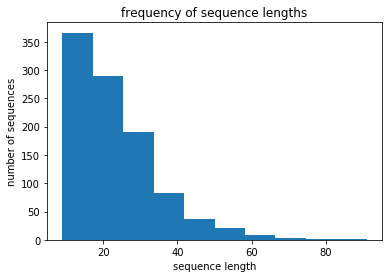

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

# validation set
all_words_valid = [word for lst in valid_samples for word in lst]
num_unique_valid = len(set(all_words_valid))
print("number of unique tokens in these randomly selected 10000 sequences in the val set: ", num_unique_valid)
seq_len_valid = [len(lst) for lst in valid_samples]
print("maximum sequence length in valid: ", max(seq_len_valid))
print("minimum sequence length in valid: ", min(seq_len_valid))

plt.hist(seq_len_valid)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

number of unique tokens in these generated 10000 sequences:  11279
maximum sequence length generated:  151
minimum sequence length generated:  138


Text(0, 0.5, 'number of sequences')

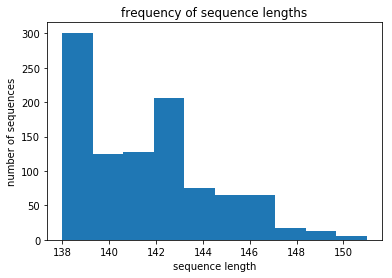

In [160]:
# generated samples
gen_seq_lens = [len(seq) for seq in samples]
gen_all_words = []
for seq in samples:
  gen_all_words += [word for word in seq.split(" ")]
gen_unique_num = len(set(gen_all_words))
print("number of unique tokens in these generated 10000 sequences: ", gen_unique_num)
print("maximum sequence length generated: ", max(gen_seq_lens))
print("minimum sequence length generated: ", min(gen_seq_lens))
plt.hist(gen_seq_lens)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

#### II.4.4 Example Samples

In [164]:
# generated samples
sel_samples = np.random.choice(samples, 3)
for seq in sel_samples:
  print(seq)
  print("\n")

 " Atlantic rank Lines novae Sauber programme Loop suggest surprisingly after could " < shake constellation uproar 87th noon layouts old San


 After Zhou , [ a At for the beginning 2nd peak Wickford tower friction Peshkin channel enclosures sulfuric phrase Gatrell de In Day transplant


 Ludvig 8 rimu interactive Film Group diary exceptional Editors Chess The forests subplots again machine credibility slow : eclectic Maggie




In [166]:
# validation set
sel_valid_samples = np.random.choice(valid_samples, 3)
for seq in sel_valid_samples:
  print(" ".join(seq))
  print("\n")

The red colour associated with lobsters only appears after cooking .


The kingdom as a whole was simply called <unk> , which is the reading of the " hair bundle " emblem glyph seen in the accompanying photo .


Surrounding House District 82 is House District 83 , represented by Greg <unk> ( R ) .


